In [16]:
from __future__ import print_function
import os,re
import pandas as pd
import numpy as np
import random
from numpy.random import RandomState
import math
import glob
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import svm
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy.contrasts import ContrastMatrix
from patsy.contrasts import Sum
import statsmodels.stats.api as sms
import statsmodels.stats.multicomp as multi
from statsmodels.regression.linear_model import OLS
from scipy.stats import sem 

import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
from scipy import stats

from scipy import sparse 

import pingouin as pg

OUTDATED_IGNORE=1
pd.options.mode.chained_assignment = None

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [17]:
WorkingPath = os.getcwd();print(WorkingPath)
DataPath = WorkingPath +'/Results/'

FigurePath = WorkingPath +'/Figures/'
if not os.path.exists(FigurePath):
    os.makedirs(FigurePath)
    
    

/Users/chengsi/Desktop/SerialBias/E8_TimeEmotion_NCP/E_4_Data_Analysis


In [18]:
# load data AllSubCleanOneBackData_feedback.csv
raw = pd.read_csv(DataPath +'/AllSubCleanBackData1.csv')
raw = raw.drop(columns=['Unnamed: 0'])

# reset index
raw['index'] = list(range(0,len(raw),1))
raw = raw.set_index('index')
raw = raw.reset_index(drop=True)

# delete unused trials
raw = raw.query('TimeOutlier != 1 & RT_Outlier != 1 & TimeUnRes != 1')
raw = raw.query('PressTimeError != 9999')

#raw['PreFeedback'] = raw['nBack_FeedbackID'].map({1: 'shorter', 2: 'shorter', 3: 'precise', 4: 'longer', 5: 'longer'})

print(np.sort(raw.SubID.unique()))
raw.head()
raw


[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21.]


,Session,BlockID,BlockType,TrialType,Condition,TimeDur,PictureID,TrialID,RT,PressTimeDur,...,ActualDur,nBack_Time_1,TimeUnRes,nBack_Time,nBack_TrialType,nBack,TimeOutlier,RT_Outlier,SubID,Trials%
0,1.0,1.0,Positive,Low,0.0,0.8,L_13,1.0,1.552811,1.088261,...,ShortDur,9999.0,0,9999.0,9999,1,0,0,4.0,96.875
2,1.0,1.0,Positive,High,LH,1.6,P_26,3.0,1.729167,1.216255,...,LongDur,1.2,0,1.2,Low,1,0,0,4.0,96.875
3,1.0,1.0,Positive,Low,HL,1.6,L_67,4.0,0.505952,1.375358,...,LongDur,1.6,0,1.6,High,1,0,0,4.0,96.875
4,1.0,1.0,Positive,Low,LL,1.2,L_80,5.0,1.117699,0.625146,...,0,1.6,0,1.6,Low,1,0,0,4.0,96.875
5,1.0,1.0,Positive,High,LH,1.2,P_50,6.0,1.682064,0.672104,...,0,1.2,0,1.2,Low,1,0,0,4.0,96.875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13432,2.0,16.0,Negative,Low,HL,0.8,L_53,636.0,0.365070,1.296014,...,ShortDur,1.4,0,1.4,High,1,0,0,8.0,98.125
13433,2.0,16.0,Negative,Low,LL,1.2,L_30,637.0,0.341288,0.927948,...,0,0.8,0,0.8,Low,1,0,0,8.0,98.125
13434,2.0,16.0,Negative,High,LH,1.2,N_79,638.0,0.306349,1.119951,...,0,1.2,0,1.2,Low,1,0,0,8.0,98.125
13435,2.0,16.0,Negative,High,HH,0.8,N_38,639.0,0.376307,1.024027,...,ShortDur,1.2,0,1.2,High,1,0,0,8.0,98.125


In [82]:
print(np.sort(raw.Age.unique()))
print(raw.Age.mean())
print(raw.Age.std())


[19. 20. 21. 22. 23. 24. 25. 26.]
22.997196120036374
1.8012436497031912


# Behavioral performance

02. March. 2024

At first we analyze the participants' performance.

## 1. Outlier

Calculate the unused trials

In [5]:
# calculate the bad performance + outlier trials
raw[['Trials%' , 'SubID']].groupby(['SubID']).describe()
UseTrials = raw[['SubID','Trials%']].groupby(['SubID']).agg({'Trials%':'mean'}).reset_index()
# summary statistics of raw data

#UseTrials.to_csv(DataPath +'/AllSubCleanOneBackData_outlier_ITI.csv')

print(100 - np.mean(UseTrials['Trials%']).round(4))
UseTrials.describe().round(3)

2.105699999999999


,SubID,Trials%
count,21.000,21.000
mean,11.000,97.894
std,6.205,0.636
min,1.000,96.562
25%,6.000,97.500
50%,11.000,97.969
75%,16.000,98.281
max,21.000,98.906


## 2. Reprodcution error

Calculate the mean reproduction error

In [6]:
# reproduction performance
raw[['PressTimeError' , 'SubID']].groupby(['SubID']).describe()
Beha = raw[['SubID','PressTimeError']].groupby(['SubID']).agg({'PressTimeError':'mean'}).reset_index()
print(sem(Beha['PressTimeError']).round(4))
Beha.describe().round(3)
#Beha.to_csv(DataPath +'/AllSubCleanOneBackData_TimeError_ITI.csv')



0.0145


,SubID,PressTimeError
count,21.000,21.000
mean,11.000,-0.025
std,6.205,0.067
min,1.000,-0.186
25%,6.000,-0.054
50%,11.000,-0.028
75%,16.000,0.006
max,21.000,0.093


In [7]:
stats_Beha = pg.ttest(Beha['PressTimeError'],0)

pg.print_table(stats_Beha, floatfmt='.3f') 


     T    dof  alternative      p-val  CI95%            cohen-d    BF10    power
------  -----  -------------  -------  -------------  ---------  ------  -------
-1.730     20  two-sided        0.099  [-0.06  0.01]      0.377   0.809    0.377



In [8]:
# reproduction performance
raw[['PressTimeDur' , 'SubID']].groupby(['SubID']).describe()
Beha = raw[['SubID','PressTimeDur']].groupby(['SubID']).agg({'PressTimeDur':'mean'}).reset_index()
print(sem(Beha['PressTimeDur']).round(4))
Beha.describe().round(3)
#Beha.to_csv(DataPath +'/AllSubCleanOneBackData_TimeError_ITI.csv')


0.0144


,SubID,PressTimeDur
count,21.000,21.000
mean,11.000,1.175
std,6.205,0.066
min,1.000,1.015
25%,6.000,1.147
50%,11.000,1.174
75%,16.000,1.210
max,21.000,1.294


## 3. Reaction time (RT)

Calculate the mean reaction time

In [9]:
# reproduction RT
raw[['RT' , 'SubID']].groupby(['SubID']).describe()
RTs = raw[['SubID','RT']].groupby(['SubID']).agg({'RT':'mean'}).reset_index()
print(sem(RTs['RT']).round(4))
RTs.describe().round(3)
#RTs.to_csv(DataPath +'/AllSubCleanOneBackData_RT_ITI.csv')



0.0485


,SubID,RT
count,21.000,21.000
mean,11.000,0.626
std,6.205,0.222
min,1.000,0.370
25%,6.000,0.485
50%,11.000,0.579
75%,16.000,0.641
max,21.000,1.362


/Users/chengsi/opt/anaconda3/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/Users/chengsi/opt/anaconda3/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


## 4. Response standard deviation

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


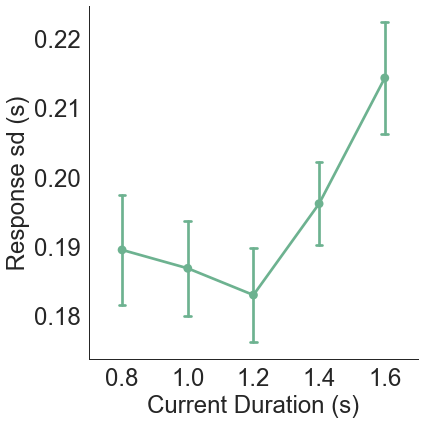

In [10]:
sns.set_theme(style = 'white', font = 'Arial',font_scale = 1.5)

paper_rc = {'lines.linewidth': 1.5, 'lines.markersize': 3}     
sns.set_context("paper", rc = paper_rc)
#color_list = sns.palplot(sns.color_palette("light:k",4))
sns.set_palette(sns.color_palette("crest",4))

plt.figure(figsize=(6,6))

PlotData = raw.groupby(['SubID','TimeDur']).agg({'PressTimeDur':'std'}).reset_index()


ax = sns.pointplot(x='TimeDur',y='PressTimeDur',data=PlotData,
                   dodge = True,errorbar=('se', 1),capsize=0.1)

# add a dashed line of y = 0
#plt.axhline(y=0, color='k', linestyle='--',linewidth=1.5)


#plt.yticks([0.14, 0.16, 0.18, 0.20, 0.22, 0.24])

# add x label "Current Duration (ms)" and y label "Error (ms)"
plt.xlabel('Current Duration (s)', fontsize=24)
plt.ylabel(' Response sd (s) ', fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

# set the tick line on or off for the axis
plt.tick_params(top=False,bottom=False,left=False,right=False)
sns.despine(top=True,right=True,left=False,bottom=False)

# set legend location and fontsize
plt.legend(loc='best',fontsize = 16)
# remove legend box
plt.gca().get_legend().get_frame().set_linewidth(0)
# remove legend
#plt.legend([],[], frameon=False)

# save figure to subfolder figs
plt.tight_layout()
plt.show()




# Performance according to emotional arousal


### 1. Reproduction error

In [11]:
Rep_Error = raw[['SubID','PressTimeDur','TrialType','BlockType']].groupby(['SubID','TrialType','BlockType']).agg({'PressTimeDur':'mean'}).reset_index()
Rep_Error.groupby(['BlockType','TrialType']).agg({'PressTimeDur': ['mean', 'sem']}).round(3)



PressTimeDur       
                            mean    sem
BlockType TrialType                    
Negative  High             1.183  0.016
          Low              1.167  0.013
Positive  High             1.186  0.015
          Low              1.165  0.016

In [12]:

anova = pg.rm_anova(data=Rep_Error, dv='PressTimeDur', within=['BlockType','TrialType'], subject='SubID', effsize="np2")
pg.print_table(anova, floatfmt='.3f')




ANOVA SUMMARY

Source                    SS    ddof1    ddof2     MS       F    p-unc    p-GG-corr    np2    eps
---------------------  -----  -------  -------  -----  ------  -------  -----------  -----  -----
BlockType              0.000        1       20  0.000   0.023    0.881        0.881  0.001  1.000
TrialType              0.007        1       20  0.007  14.062    0.001        0.001  0.413  1.000
BlockType * TrialType  0.000        1       20  0.000   0.311    0.583        0.583  0.015  1.000



In [13]:
raw_Rep_Error = Rep_Error

raw_Rep_Error['BlockType_Num'] = raw_Rep_Error['BlockType'].map({'Negative': 1, 'Positive': 2})
raw_Rep_Error['TrialType_Num'] = raw_Rep_Error['TrialType'].map({'Low': 1, 'High': 2})

posthoc = pg.pairwise_tests(data=raw_Rep_Error, dv='PressTimeDur', within=['BlockType_Num','TrialType_Num'], subject='SubID')
posthoc.round(3)



,Contrast,BlockType_Num,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,BlockType_Num,-,1,2,True,True,-0.151,20.0,two-sided,0.881,0.23,-0.015
1,TrialType_Num,-,1,2,True,True,-3.750,20.0,two-sided,0.001,29.556,-0.272
2,BlockType_Num * TrialType_Num,1,1,2,True,True,-2.337,20.0,two-sided,0.030,2.052,-0.241
3,BlockType_Num * TrialType_Num,2,1,2,True,True,-3.654,20.0,two-sided,0.002,24.349,-0.284


#### 1. Positive

#### 2. Negative

<Figure size 432x432 with 0 Axes>

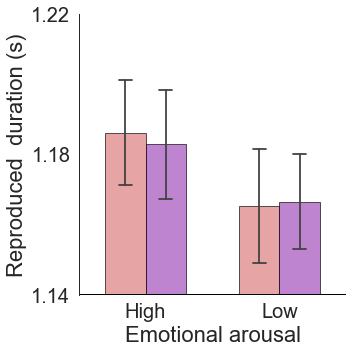

In [14]:
sns.set_theme(style = 'white', font = 'Arial',font_scale = 1.5)

paper_rc = {'lines.linewidth': 1, 'lines.markersize': 2}     
sns.set_context("paper", rc = paper_rc)

colors_list = ['lightcoral','mediumorchid']

plt.figure(figsize=(6,6))

PlotDataError = Rep_Error
PlotData = PlotDataError.copy() 
PlotData['PressTimeDur'] = PlotData['PressTimeDur']

#ax = sns.boxplot(x='TrialType',y='PressTimeError',hue = 'BlockType',data=PlotData,
#                  hue_order=['Positive', 'Negative'],
#                  palette=colors_list, width=0.75)

#for patch in ax.patches:
#    r, g, b, a = patch.get_facecolor()
#    patch.set_facecolor((r, g, b, .5))
  

#ax = sns.swarmplot(x='TrialType', y='PressTimeError', hue = 'BlockType',data=PlotData,
#                   hue_order=['Positive', 'Negative'],dodge=True, 
#                   palette=colors_list,size=6,edgecolor="gray", linewidth=0.8)


ax = sns.catplot(x='TrialType',y='PressTimeDur',hue = 'BlockType', kind = 'bar',data=PlotData,
                 hue_order=['Positive', 'Negative'],
                 width=0.6,errorbar=('se', 1), legend=False,
                 palette=colors_list, alpha=0.8,aspect=1, capsize=0.1,edgecolor='black')

#sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
#ax.set_ylim(bottom=1)

ax.set(ylim=(1.14, 1.22))
plt.yticks([1.14, 1.18, 1.22])

plt.axhline(y=1.14, color='black', linestyle='-',linewidth=2)

plt.xlabel('Emotional arousal', fontsize=22)
ax.set_xticklabels(['High','Low'], fontsize=20)
plt.ylabel('Reproduced  duration (s)', fontsize=22)
plt.yticks(fontsize=20)

#plt.legend([],[], frameon=False)

#plt.gca().invert_yaxis()
sns.despine(top=True,right=True,left=False,bottom=True)

plt.tick_params(top=False,bottom=False,left=False,right=False)

plt.tight_layout()
plt.savefig(FigurePath+"/ResponseErrors.png", dpi=600)

plt.show() 


### 2. RTs

In [15]:
RTs = raw[['SubID','RT','TrialType','BlockType']].groupby(['SubID','TrialType','BlockType']).agg({'RT':'mean'}).reset_index()
RTs.groupby(['BlockType','TrialType']).agg({'RT': ['mean', 'sem']}).round(3)


RT       
                      mean    sem
BlockType TrialType              
Negative  High       0.633  0.052
          Low        0.612  0.043
Positive  High       0.641  0.051
          Low        0.617  0.049

In [16]:

anova = pg.rm_anova(data=RTs, dv='RT', within=['BlockType','TrialType'], subject='SubID', effsize="np2")
pg.print_table(anova, floatfmt='.3f')



ANOVA SUMMARY

Source                    SS    ddof1    ddof2     MS      F    p-unc    p-GG-corr    np2    eps
---------------------  -----  -------  -------  -----  -----  -------  -----------  -----  -----
BlockType              0.001        1       20  0.001  0.322    0.577        0.577  0.016  1.000
TrialType              0.011        1       20  0.011  7.035    0.015        0.015  0.260  1.000
BlockType * TrialType  0.000        1       20  0.000  0.042    0.840        0.840  0.002  1.000



In [17]:
raw_RTs = RTs

raw_RTs['BlockType_Num'] = raw_RTs['BlockType'].map({'Negative': 1, 'Positive': 2})
raw_RTs['TrialType_Num'] = raw_RTs['TrialType'].map({'Low': 1, 'High': 2})

posthoc = pg.pairwise_tests(data=raw_RTs, dv='RT', within=['BlockType_Num','TrialType_Num'], subject='SubID')
posthoc.round(3)




,Contrast,BlockType_Num,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,BlockType_Num,-,1,2,True,True,-0.568,20.0,two-sided,0.577,0.263,-0.026
1,TrialType_Num,-,1,2,True,True,-2.652,20.0,two-sided,0.015,3.549,-0.099
2,BlockType_Num * TrialType_Num,1,1,2,True,True,-1.495,20.0,two-sided,0.150,0.597,-0.094
3,BlockType_Num * TrialType_Num,2,1,2,True,True,-3.459,20.0,two-sided,0.002,16.47,-0.102


#### 1. Positive

#### 2. Negative

<Figure size 432x432 with 0 Axes>

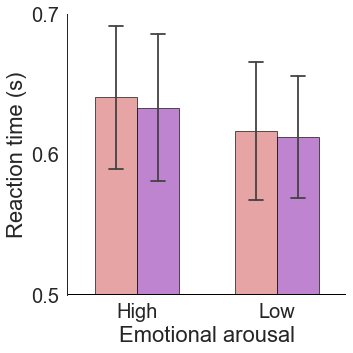

In [18]:
sns.set_theme(style = 'white', font = 'Arial',font_scale = 1.5)

paper_rc = {'lines.linewidth': 1, 'lines.markersize': 2}     
sns.set_context("paper", rc = paper_rc)

colors_list = ['lightcoral','mediumorchid']

plt.figure(figsize=(6,6))

PlotDataRTs = RTs
PlotData = PlotDataRTs.copy() 
PlotData['RT'] = PlotData['RT']

#ax = sns.boxplot(x='BlockType',y='RT',hue = 'TrialType',data=PlotData,
#                  hue_order=['High', 'Low'],
#                  palette=colors_list, width=0.75)

#for patch in ax.patches:
#    r, g, b, a = patch.get_facecolor()
#    patch.set_facecolor((r, g, b, .5))

#ax = sns.swarmplot(x='BlockType', y='RT', hue = 'TrialType',data=PlotData,
#                   hue_order=['High', 'Low'],dodge=True, 
#                   palette=colors_list,size=6,edgecolor="gray", linewidth=0.8)

ax = sns.catplot(x='TrialType',y='RT',hue = 'BlockType', kind = 'bar',data=PlotData,
                 hue_order=['Positive', 'Negative'],
                 width=0.6,errorbar=('se', 1), legend=False,
                 palette=colors_list, alpha=0.8,aspect=1, capsize=0.1,edgecolor='black')

#plt.yticks([0, 0.2, 0.4, 0.6, 0.8])

ax.set(ylim=(0.5, 0.7))
plt.yticks([0.5, 0.6, 0.7])

plt.axhline(y=0.5, color='black', linestyle='-',linewidth=2)


plt.xlabel('Emotional arousal', fontsize=22)
ax.set_xticklabels(['High','Low'], fontsize=20)
plt.ylabel('Reaction time (s)', fontsize=22)
plt.yticks(fontsize=20)

plt.legend([],[], frameon=False)
#plt.gca().invert_yaxis()
sns.despine(top=True,right=True,left=False,bottom=True)

plt.tick_params(top=False,bottom=False,left=False,right=False)

plt.tight_layout()
plt.savefig(FigurePath+"/RTs.png", dpi=600)
plt.show() 


### 3. Response standard deviation

In [19]:
Std = raw[['SubID','PressTimeDur','TrialType','BlockType']].groupby(['SubID','TrialType','BlockType']).agg({'PressTimeDur':'std'}).reset_index()

Std['stds'] = Std['PressTimeDur']
Std.groupby(['BlockType','TrialType']).agg({'stds': ['mean', 'sem']}).round(3)



stds       
                      mean    sem
BlockType TrialType              
Negative  High       0.247  0.007
          Low        0.246  0.007
Positive  High       0.251  0.007
          Low        0.254  0.008

In [20]:
anova = pg.rm_anova(data=Std, dv='PressTimeDur', within=['BlockType','TrialType'], subject='SubID', effsize="np2")
pg.print_table(anova, floatfmt='.3f')



ANOVA SUMMARY

Source                    SS    ddof1    ddof2     MS      F    p-unc    p-GG-corr    np2    eps
---------------------  -----  -------  -------  -----  -----  -------  -----------  -----  -----
BlockType              0.001        1       20  0.001  1.767    0.199        0.199  0.081  1.000
TrialType              0.000        1       20  0.000  0.052    0.822        0.822  0.003  1.000
BlockType * TrialType  0.000        1       20  0.000  0.220    0.644        0.644  0.011  1.000



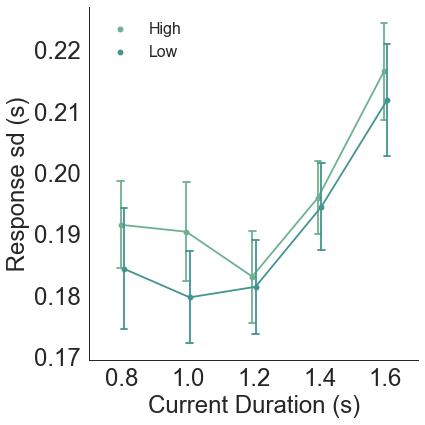

In [21]:
sns.set_theme(style = 'white', font = 'Arial',font_scale = 1.5)

paper_rc = {'lines.linewidth': 1, 'lines.markersize': 2}     
sns.set_context("paper", rc = paper_rc)
#color_list = sns.palplot(sns.color_palette("light:k",4))
sns.set_palette(sns.color_palette("crest",4))

plt.figure(figsize=(6,6))

PlotData = raw.groupby(['SubID','TimeDur','TrialType']).agg({'PressTimeDur':'std'}).reset_index()


ax = sns.pointplot(x='TimeDur',y='PressTimeDur',hue = 'TrialType', data=PlotData,
                   dodge = True,errorbar=('se', 1),capsize=0.1)

# add a dashed line of y = 0
#plt.axhline(y=0, color='k', linestyle='--',linewidth=1.5)


#plt.yticks([0.14, 0.16, 0.18, 0.20, 0.22, 0.24])

# add x label "Current Duration (ms)" and y label "Error (ms)"
plt.xlabel('Current Duration (s)', fontsize=24)
plt.ylabel(' Response sd (s) ', fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

# set the tick line on or off for the axis
plt.tick_params(top=False,bottom=False,left=False,right=False)
sns.despine(top=True,right=True,left=False,bottom=False)

# set legend location and fontsize
plt.legend(loc='best',fontsize = 16)
# remove legend box
plt.gca().get_legend().get_frame().set_linewidth(0)
# remove legend
#plt.legend([],[], frameon=False)

# save figure to subfolder figs
plt.tight_layout()
plt.show()




#### 1. Positive

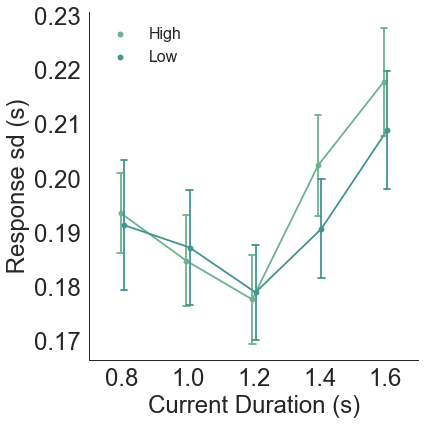

In [22]:
sns.set_theme(style = 'white', font = 'Arial',font_scale = 1.5)

paper_rc = {'lines.linewidth': 1, 'lines.markersize': 2}     
sns.set_context("paper", rc = paper_rc)
#color_list = sns.palplot(sns.color_palette("light:k",4))
sns.set_palette(sns.color_palette("crest",4))

plt.figure(figsize=(6,6))

raw_Pos = raw.drop(raw[raw['BlockType']=='Negative'].index)
PlotData = raw_Pos.groupby(['SubID','TimeDur','TrialType']).agg({'PressTimeDur':'std'}).reset_index()


ax = sns.pointplot(x='TimeDur',y='PressTimeDur',hue = 'TrialType', data=PlotData,
                   dodge = True,errorbar=('se', 1),capsize=0.1)

# add a dashed line of y = 0
#plt.axhline(y=0, color='k', linestyle='--',linewidth=1.5)


#plt.yticks([0.14, 0.16, 0.18, 0.20, 0.22, 0.24])

# add x label "Current Duration (ms)" and y label "Error (ms)"
plt.xlabel('Current Duration (s)', fontsize=24)
plt.ylabel(' Response sd (s) ', fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

# set the tick line on or off for the axis
plt.tick_params(top=False,bottom=False,left=False,right=False)
sns.despine(top=True,right=True,left=False,bottom=False)

# set legend location and fontsize
plt.legend(loc='best',fontsize = 16)
# remove legend box
plt.gca().get_legend().get_frame().set_linewidth(0)
# remove legend
#plt.legend([],[], frameon=False)

# save figure to subfolder figs
plt.tight_layout()
plt.show()




#### 2. Negative

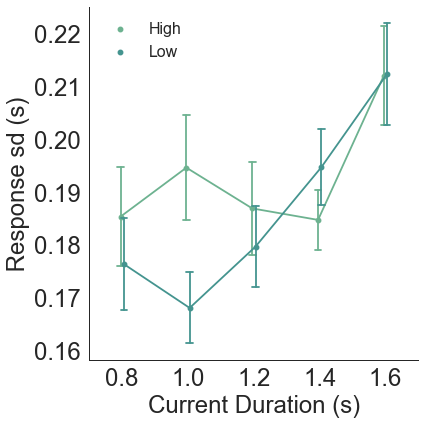

In [23]:
sns.set_theme(style = 'white', font = 'Arial',font_scale = 1.5)

paper_rc = {'lines.linewidth': 1, 'lines.markersize': 2}     
sns.set_context("paper", rc = paper_rc)
#color_list = sns.palplot(sns.color_palette("light:k",4))
sns.set_palette(sns.color_palette("crest",4))

plt.figure(figsize=(6,6))

raw_Neg = raw.drop(raw[raw['BlockType']=='Positive'].index)
PlotData = raw_Neg.groupby(['SubID','TimeDur','TrialType']).agg({'PressTimeDur':'std'}).reset_index()


ax = sns.pointplot(x='TimeDur',y='PressTimeDur',hue = 'TrialType', data=PlotData,
                   dodge = True,errorbar=('se', 1),capsize=0.1)

# add a dashed line of y = 0
#plt.axhline(y=0, color='k', linestyle='--',linewidth=1.5)


#plt.yticks([0.14, 0.16, 0.18, 0.20, 0.22, 0.24])

# add x label "Current Duration (ms)" and y label "Error (ms)"
plt.xlabel('Current Duration (s)', fontsize=24)
plt.ylabel(' Response sd (s) ', fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

# set the tick line on or off for the axis
plt.tick_params(top=False,bottom=False,left=False,right=False)
sns.despine(top=True,right=True,left=False,bottom=False)

# set legend location and fontsize
plt.legend(loc='best',fontsize = 16)
# remove legend box
plt.gca().get_legend().get_frame().set_linewidth(0)
# remove legend
#plt.legend([],[], frameon=False)

# save figure to subfolder figs
plt.tight_layout()
plt.show()



## Central tendency effect

In [18]:
rawLMM = raw 
rawLMM['BlockType'] = rawLMM['BlockType'].astype('category')
rawLMM['TrialType'] = rawLMM['TrialType'].astype('category')
mPM = (rawLMM.groupby(['TimeDur', 'BlockType','TrialType', 'SubID'])
       .agg(sPM=('PressTimeError', 'mean'))
       .reset_index())
mPM['TimeDur'] = mPM['TimeDur'] - 1.2

mmPM = (mPM.groupby(['TimeDur', 'BlockType','TrialType'])
        .agg(pm=('sPM', 'mean'),
             se=('sPM', lambda x: np.std(x)/np.sqrt(len(x))),
             n=('sPM', 'count'))
        .reset_index())
mod1 = smf.mixedlm("sPM ~ TimeDur*BlockType*TrialType", mPM, groups=mPM["SubID"]).fit(reml=False)
mod1.summary()

/Users/chengsi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Mixed Linear Model Regression Results
==========================================================================================
Model:                        MixedLM             Dependent Variable:             sPM     
No. Observations:             420                 Method:                         ML      
No. Groups:                   21                  Scale:                          0.0039  
Min. group size:              20                  Log-Likelihood:                 536.0918
Max. group size:              20                  Converged:                      Yes     
Mean group size:              20.0                                                        
------------------------------------------------------------------------------------------
                                               Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------
Intercept                                      -0.610    0.030 -20.367 0.000 -0.669 -0.551
BlockType[T.Positive]                           0.034    0.038   0.906 0.365 -0.040  0.108
TrialType[T.Low]                                0.014    0.038   0.363 0.717 -0.060  0.087
BlockType[T.Positive]:TrialType[T.Low]         -0.010    0.053  -0.194 0.846 -0.115  0.094
TimeDur                                        -0.493    0.022 -22.865 0.000 -0.536 -0.451
TimeDur:BlockType[T.Positive]                   0.025    0.031   0.811 0.418 -0.035  0.085
TimeDur:TrialType[T.Low]                        0.024    0.031   0.800 0.423 -0.035  0.084
TimeDur:BlockType[T.Positive]:TrialType[T.Low] -0.004    0.043  -0.091 0.928 -0.089  0.081
Group Var                                       0.004    0.021                            
==========================================================================================

"""

In [89]:
rawLMM
mmPM

,TimeDur,BlockType,TrialType,pm,se,n
0,-0.4,Negative,High,0.152796,0.020886,21
1,-0.4,Negative,Low,0.140546,0.014977,21
2,-0.4,Positive,High,0.158868,0.017471,21
3,-0.4,Positive,Low,0.130643,0.016573,21
4,-0.2,Negative,High,0.105193,0.015477,21
5,-0.2,Negative,Low,0.065779,0.015387,21
6,-0.2,Positive,High,0.098201,0.016797,21
7,-0.2,Positive,Low,0.067728,0.015812,21
8,0.0,Negative,High,-0.004339,0.017343,21
9,0.0,Negative,Low,-0.019733,0.015067,21


In [7]:


rawLMM = raw 
rawLMM['BlockType'] = rawLMM['BlockType'].astype('category')
rawLMM['TrialType'] = rawLMM['TrialType'].astype('category')
mPM = (rawLMM.groupby(['TimeDur', 'BlockType','TrialType', 'SubID'])
       .agg(sPM=('PressTimeError', 'mean'))
       .reset_index())

mPM['TimeDur'] = mPM['TimeDur'] - 1.2
mmPM = (mPM.groupby(['TimeDur', 'BlockType','TrialType'])
        .agg(pm=('sPM', 'mean'),
             se=('sPM', lambda x: np.std(x)/np.sqrt(len(x))),
             n=('sPM', 'count'))
        .reset_index())

contrast_dict = {
    "BlockType": Sum().code_without_intercept([0, 1]),  # Sum contrasts for two-level coding
    "TrialType": Sum().code_without_intercept([0, 1])}   # Sum contrasts for two-level coding

mod1 = smf.mixedlm("sPM ~ TimeDur*C(BlockType, Sum)*C(TrialType, Sum)", mPM, groups = mPM["SubID"]).fit(reml=False)
mod1.summary()


/Users/chengsi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                   Mixed Linear Model Regression Results
===========================================================================================================
Model:                               MixedLM                  Dependent Variable:                  sPM     
No. Observations:                    420                      Method:                              ML      
No. Groups:                          21                       Scale:                               0.0039  
Min. group size:                     20                       Log-Likelihood:                      536.0918
Max. group size:                     20                       Converged:                           Yes     
Mean group size:                     20.0                                                                  
-----------------------------------------------------------------------------------------------------------
                                                                Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                                       -0.025    0.014  -1.772 0.076 -0.053  0.003
C(BlockType, Sum)[S.Negative]                                   -0.001    0.003  -0.261 0.794 -0.007  0.005
C(TrialType, Sum)[S.High]                                        0.009    0.003   3.025 0.002  0.003  0.015
C(BlockType, Sum)[S.Negative]:C(TrialType, Sum)[S.High]         -0.001    0.003  -0.460 0.645 -0.007  0.005
TimeDur                                                         -0.470    0.011 -43.542 0.000 -0.491 -0.449
TimeDur:C(BlockType, Sum)[S.Negative]                           -0.011    0.011  -1.055 0.291 -0.033  0.010
TimeDur:C(TrialType, Sum)[S.High]                               -0.011    0.011  -1.041 0.298 -0.032  0.010
TimeDur:C(BlockType, Sum)[S.Negative]:C(TrialType, Sum)[S.High] -0.001    0.011  -0.091 0.928 -0.022  0.020
Group Var                                                        0.004    0.021                            
===========================================================================================================

"""

In [8]:
contrast_dict


{'BlockType': ContrastMatrix(array([[ 1.],
                       [-1.]]),
                ['[S.0]']),
 'TrialType': ContrastMatrix(array([[ 1.],
                       [-1.]]),
                ['[S.0]'])}

In [19]:
mPM.to_excel("a.xlsx")

<ipython-input-19-2ffb39999de8>:1: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.7' currently installed).
  mPM.to_excel("a.xlsx")


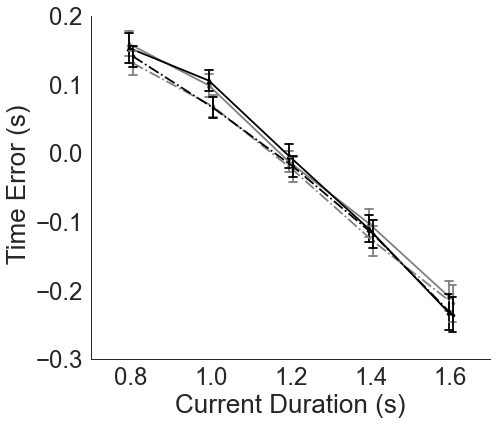

In [19]:
sns.set_theme(style = 'white', font = 'Arial',font_scale = 1.5)

paper_rc = {'lines.linewidth': 1, 'lines.markersize': 2}     
sns.set_context("paper", rc = paper_rc)

colors_list = ['#DC0000FF','#3C5488FF']
colors_list = ['lightcoral','lightcoral']
colors_list = ['#808080','#808080']
#colors_list = ['dimgray','dimgray']

# data for plotting
PlotData = pd.DataFrame()
PlotData = raw.groupby(['BlockType','TrialType','SubID','TimeDur']).agg({'PressTimeError':'mean'}).reset_index()

### ============= Positive ==============
PlotData_Pos = PlotData.drop(PlotData[PlotData['BlockType']=='Negative'].index)

plt.figure(figsize=(7,6))
ax = sns.pointplot(x='TimeDur',y='PressTimeError',hue="TrialType",data=PlotData_Pos,
                   hue_order=['High', 'Low'],palette=colors_list,
                   linestyles = ['-','-.'],markers = ['^','.'],
                   dodge = True,errorbar=('se', 1),capsize=0.1)

#plt.axhline(y=0, color='k', linestyle='--',linewidth=1)



#plt.tight_layout()

#plt.show()

colors_list = ['mediumorchid','mediumorchid']
colors_list = ['#000000','#000000']
#colors_list = ['silver','silver']
### ============= Negative ==============
PlotData_Neg = PlotData.drop(PlotData[PlotData['BlockType']=='Positive'].index)

ax = sns.pointplot(x='TimeDur',y='PressTimeError',hue="TrialType",data=PlotData_Neg,
                   hue_order=['High', 'Low'],palette=colors_list,
                   linestyles = ['-','-.'],markers = ['^','.'],
                   dodge = True,errorbar=('se', 1),capsize=0.1)

#plt.axhline(y=0, color='k', linestyle='--',linewidth=1)

sns.despine(top=True,right=True,left=False,bottom=False)

plt.yticks([-0.3, -0.2, -0.1, 0.0, 0.1, 0.2])

plt.xlabel('Current Duration (s)', fontsize=26)
plt.ylabel(' Time Error (s)', fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

plt.tick_params(top=False,bottom=False,left=False,right=False)

plt.legend(loc='best',fontsize = 16)
plt.gca().get_legend().get_frame().set_linewidth(0)
plt.legend([],[], frameon=False)

plt.tight_layout()
plt.savefig(FigurePath+"/Valence_CT_Error_bar.png", dpi=600)
#plt.show()




sns.set_theme(style = 'white', font = 'Arial',font_scale = 1.5)

paper_rc = {'lines.linewidth': 1, 'lines.markersize': 2}     
sns.set_context("paper", rc = paper_rc)

colors_list = ['#DC0000FF','#3C5488FF']

# data for plotting
PlotData = pd.DataFrame()
PlotData = raw.groupby(['BlockType','TrialType','SubID','TimeDur']).agg({'PressTimeError':'mean'}).reset_index()

### ============= Positive ==============
PlotData_Pos = PlotData.drop(PlotData[PlotData['BlockType']=='Negative'].index)

plt.figure(figsize=(7,6))
ax = sns.pointplot(x='TimeDur',y='PressTimeError',hue="TrialType",data=PlotData_Pos,
                   hue_order=['High', 'Low'],palette=colors_list,
                   linestyles = ['-','-.'],markers = ['^','.'],
                   dodge = True,errorbar=('se', 1),capsize=0.1)

#plt.axhline(y=0, color='k', linestyle='--',linewidth=1)

sns.despine(top=True,right=True,left=False,bottom=False)

plt.yticks([-0.3, -0.2, -0.1, 0.0, 0.1, 0.2])

plt.xlabel('Current Duration (s)', fontsize=26)
plt.ylabel(' Time Error (s)', fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

plt.tick_params(top=False,bottom=False,left=False,right=False)

plt.legend(loc='best',fontsize = 16)
plt.gca().get_legend().get_frame().set_linewidth(0)
plt.legend([],[], frameon=False)

#plt.tight_layout()

#plt.show()


### ============= Negative ==============
PlotData_Neg = PlotData.drop(PlotData[PlotData['BlockType']=='Positive'].index)

plt.figure(figsize=(7,6))
ax = sns.pointplot(x='TimeDur',y='PressTimeError',hue="TrialType",data=PlotData_Neg,
                   hue_order=['High', 'Low'],palette=colors_list,
                   linestyles = ['-','-.'],markers = ['^','.'],
                   dodge = True,errorbar=('se', 1),capsize=0.1)

#plt.axhline(y=0, color='k', linestyle='--',linewidth=1)

sns.despine(top=True,right=True,left=False,bottom=False)

plt.yticks([-0.3, -0.2, -0.1, 0.0, 0.1, 0.2])

plt.xlabel('Current Duration (s)', fontsize=26)
plt.ylabel(' Time Error (s)', fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

plt.tick_params(top=False,bottom=False,left=False,right=False)

plt.legend(loc='best',fontsize = 16)
plt.gca().get_legend().get_frame().set_linewidth(0)
plt.legend([],[], frameon=False)

#plt.tight_layout()

#plt.show()




In [20]:
reg_BlockType = pd.DataFrame(columns=['BlockType', 'TrialType','SubID', 'Intercept', 'Slope', 'p'])

rawCT = raw 
rawCT['TimeDur'] = rawCT['TimeDur']-1.2

for i in rawCT['BlockType'].unique():
    for j in rawCT['TrialType'].unique():
        for k in rawCT['SubID'].unique():
            sub = rawCT.query('BlockType == @i & TrialType == @j & SubID == @k')
            model = smf.ols('PressTimeError ~ TimeDur', data=sub).fit()
            reg_BlockType = pd.concat([reg_BlockType, pd.DataFrame({
                'BlockType': i, 
                'TrialType': j, 
                'SubID': k, 
                'Intercept': model.params[0], 
                'Slope': model.params[1], 
                'p': model.pvalues[1]
            }, index=[0])], ignore_index=True)
            
            reg_BlockType['IPs'] = -(reg_BlockType['Intercept'])/(reg_BlockType['Slope'])
            
reg_BlockType.head()


,BlockType,TrialType,SubID,Intercept,Slope,p,IPs
0,Positive,Low,4.0,-0.184798,-0.864952,1.746436e-28,-0.213651
1,Positive,Low,16.0,-0.077620,-0.492176,6.627286e-15,-0.157708
2,Positive,Low,14.0,-0.083501,-0.289819,3.564943e-07,-0.288113
3,Positive,Low,3.0,-0.104792,-0.595114,3.843385e-24,-0.176087
4,Positive,Low,9.0,-0.057262,-0.310384,4.411639e-10,-0.184489


In [21]:
reg_BlockType.groupby(['BlockType','TrialType']).agg({'Slope': ['mean', 'sem'], 'IPs': ['mean', 'sem'], 'Intercept': ['mean', 'sem']}).round(3)


Slope           IPs        Intercept       
                      mean    sem   mean    sem      mean    sem
BlockType TrialType                                             
Negative  High      -0.494  0.043 -0.014  0.032    -0.018  0.016
          Low       -0.469  0.042 -0.015  0.054    -0.034  0.013
Positive  High      -0.469  0.034 -0.010  0.032    -0.014  0.015
          Low       -0.448  0.039 -0.041  0.047    -0.035  0.016

#### 1. Slope

In [29]:
anova = pg.rm_anova(data=reg_BlockType, dv='Slope', within=['BlockType','TrialType'], subject='SubID', detailed=True)
anova.round(3)



,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,BlockType,0.011,1,20,0.011,2.274,0.147,0.147,0.004,1.0
1,TrialType,0.011,1,20,0.011,1.607,0.219,0.219,0.004,1.0
2,BlockType * TrialType,0.000,1,20,0.000,0.037,0.849,0.849,0.000,1.0


In [30]:
raw_reg_BlockType = reg_BlockType

raw_reg_BlockType['BlockType_Num'] = raw_reg_BlockType['BlockType'].map({'Negative': 1, 'Positive': 2})
raw_reg_BlockType['TrialType_Num'] = raw_reg_BlockType['TrialType'].map({'Low': 1, 'High': 2})

posthoc = pg.pairwise_tests(data=raw_reg_BlockType, dv='Slope', within=['BlockType_Num','TrialType_Num'], subject='SubID')
posthoc.round(3)



,Contrast,BlockType_Num,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,BlockType_Num,-,1,2,True,True,-1.508,20.0,two-sided,0.147,0.606,-0.128
1,TrialType_Num,-,1,2,True,True,1.268,20.0,two-sided,0.219,0.459,0.126
2,BlockType_Num * TrialType_Num,1,1,2,True,True,1.101,20.0,two-sided,0.284,0.388,0.126
3,BlockType_Num * TrialType_Num,2,1,2,True,True,1.065,20.0,two-sided,0.300,0.375,0.120


<Figure size 432x432 with 0 Axes>

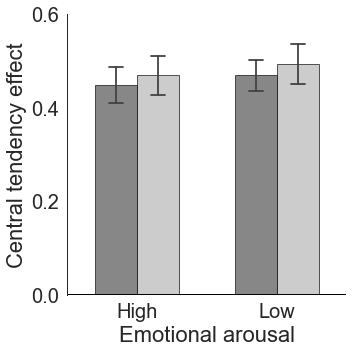

In [22]:
sns.set_theme(style = 'white', font = 'Arial',font_scale = 1.5)

paper_rc = {'lines.linewidth': 1, 'lines.markersize': 2}     
sns.set_context("paper", rc = paper_rc)

colors_list = ['lightcoral','mediumorchid']
colors_list = ['dimgray','silver']

plt.figure(figsize=(6,6))

PlotData_slope = reg_BlockType
PlotData = PlotData_slope.copy() 
PlotData['Slope'] = abs(PlotData['Slope'])

#ax = sns.boxplot(x='BlockType',y='Slope',hue = 'TrialType',data=PlotData,
#                  hue_order=['High', 'Low'],
#                  palette=colors_list, width=0.75)

#for patch in ax.patches:
#    r, g, b, a = patch.get_facecolor()
#    patch.set_facecolor((r, g, b, .5))

#ax = sns.swarmplot(x='BlockType', y='Slope', hue = 'TrialType',data=PlotData,
#                   hue_order=['High', 'Low'],dodge=True, 
#                   palette=colors_list,size=6,edgecolor="gray", linewidth=0.8)

ax = sns.catplot(x='TrialType',y='Slope',hue = 'BlockType', kind = 'bar',data=PlotData,
                 hue_order=['Positive', 'Negative'],
                 width=0.6,errorbar=('se', 1), legend=False,
                 palette=colors_list, alpha=0.8,aspect=1, capsize=0.1,edgecolor='black')

plt.yticks([0, 0.2, 0.4, 0.6])

plt.axhline(y=0, color='black', linestyle='-',linewidth=2)


plt.xlabel('Emotional arousal', fontsize=22)
ax.set_xticklabels(['High','Low'], fontsize=20)
plt.ylabel('Central tendency effect', fontsize=22)
plt.yticks(fontsize=20)

plt.legend([],[], frameon=False)
#plt.gca().invert_yaxis()
sns.despine(top=True,right=True,left=False,bottom=True)

plt.tick_params(top=False,bottom=False,left=False,right=False)

plt.tight_layout()
plt.savefig(FigurePath+"/Res_CT_bar.png", dpi=600)
#plt.savefig(FigurePath+"/Res_Error_bar.eps", dpi=600)
plt.show() 


#### 2. IPs

In [133]:
anova = pg.rm_anova(data=reg_BlockType, dv='IPs', within=['BlockType','TrialType'], subject='SubID', detailed=True)
anova.round(3)


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,BlockType,0.003,1,20,0.003,0.396,0.536,0.536,0.001,1.0
1,TrialType,0.006,1,20,0.006,0.327,0.574,0.574,0.002,1.0
2,BlockType * TrialType,0.005,1,20,0.005,1.533,0.230,0.230,0.002,1.0


In [134]:
raw_reg_BlockType = reg_BlockType

raw_reg_BlockType['BlockType_Num'] = raw_reg_BlockType['BlockType'].map({'Negative': 1, 'Positive': 2})
raw_reg_BlockType['TrialType_Num'] = raw_reg_BlockType['TrialType'].map({'Low': 1, 'High': 2})

posthoc = pg.pairwise_tests(data=raw_reg_BlockType, dv='IPs', within=['BlockType_Num','TrialType_Num'], subject='SubID')
posthoc.round(3)



,Contrast,BlockType_Num,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,BlockType_Num,-,1,2,True,True,0.629,20.0,two-sided,0.536,0.272,0.060
1,TrialType_Num,-,1,2,True,True,-0.572,20.0,two-sided,0.574,0.264,-0.086
2,BlockType_Num * TrialType_Num,1,1,2,True,True,-0.032,20.0,two-sided,0.975,0.228,-0.006
3,BlockType_Num * TrialType_Num,2,1,2,True,True,-1.279,20.0,two-sided,0.216,0.465,-0.169


<Figure size 432x432 with 0 Axes>

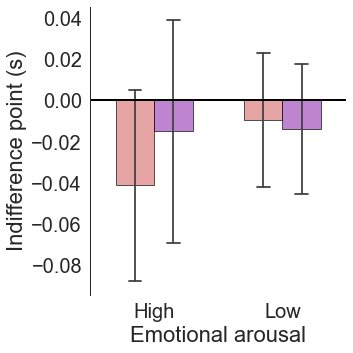

In [135]:
sns.set_theme(style = 'white', font = 'Arial',font_scale = 1.5)

paper_rc = {'lines.linewidth': 1, 'lines.markersize': 2}     
sns.set_context("paper", rc = paper_rc)

colors_list = ['lightcoral','mediumorchid']

plt.figure(figsize=(6,6))

PlotData_slope = reg_BlockType
PlotData = PlotData_slope.copy() 
PlotData['IPs'] = PlotData['IPs']

#ax = sns.boxplot(x='BlockType',y='IPs',hue = 'TrialType',data=PlotData,
#                  hue_order=['High', 'Low'],
#                  palette=colors_list, width=0.75)

#for patch in ax.patches:
#    r, g, b, a = patch.get_facecolor()
#    patch.set_facecolor((r, g, b, .5))

#ax = sns.swarmplot(x='BlockType', y='IPs', hue = 'TrialType',data=PlotData,
#                   hue_order=['High', 'Low'],dodge=True, 
#                   palette=colors_list,size=6,edgecolor="gray", linewidth=0.8)

ax = sns.catplot(x='TrialType',y='IPs',hue = 'BlockType', kind = 'bar',data=PlotData,
                 hue_order=['Positive', 'Negative'],
                 width=0.6,errorbar=('se', 1), legend=False,
                 palette=colors_list, alpha=0.8,aspect=1, capsize=0.1,edgecolor='black')

#plt.yticks([0, 0.4, 0.8, 1.2])

plt.axhline(y=0, color='black', linestyle='-',linewidth=2)


plt.xlabel('Emotional arousal', fontsize=22)
ax.set_xticklabels(['High','Low'], fontsize=20)
plt.ylabel('Indifference point (s)', fontsize=22)
plt.yticks(fontsize=20)

plt.legend([],[], frameon=False)
#plt.gca().invert_yaxis()
sns.despine(top=True,right=True,left=False,bottom=True)

plt.tick_params(top=False,bottom=False,left=False,right=False)

plt.tight_layout()
#plt.savefig(FigurePath+"/Res_Error_bar.png", dpi=600)
#plt.savefig(FigurePath+"/Res_Error_bar.eps", dpi=600)
plt.show() 



#### 3. Intercept

In [32]:
anova = pg.rm_anova(data=reg_BlockType, dv='Intercept', within=['BlockType','TrialType'], subject='SubID', detailed=True)
anova.round(3)



,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,BlockType,0.000,1,20,0.000,0.063,0.804,0.804,0.000,1.0
1,TrialType,0.007,1,20,0.007,13.555,0.001,0.001,0.018,1.0
2,BlockType * TrialType,0.000,1,20,0.000,0.501,0.487,0.487,0.000,1.0


In [33]:
raw_reg_BlockType = reg_BlockType

raw_reg_BlockType['BlockType_Num'] = raw_reg_BlockType['BlockType'].map({'Negative': 1, 'Positive': 2})
raw_reg_BlockType['TrialType_Num'] = raw_reg_BlockType['TrialType'].map({'Low': 1, 'High': 2})

posthoc = pg.pairwise_tests(data=raw_reg_BlockType, dv='Intercept', within=['BlockType_Num','TrialType_Num'], subject='SubID')
posthoc.round(3)



,Contrast,BlockType_Num,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,BlockType_Num,-,1,2,True,True,-0.251,20.0,two-sided,0.804,0.234,-0.024
1,TrialType_Num,-,1,2,True,True,-3.682,20.0,two-sided,0.001,25.744,-0.267
2,BlockType_Num * TrialType_Num,1,1,2,True,True,-2.199,20.0,two-sided,0.040,1.634,-0.228
3,BlockType_Num * TrialType_Num,2,1,2,True,True,-3.849,20.0,two-sided,0.001,36.161,-0.287


<Figure size 432x432 with 0 Axes>

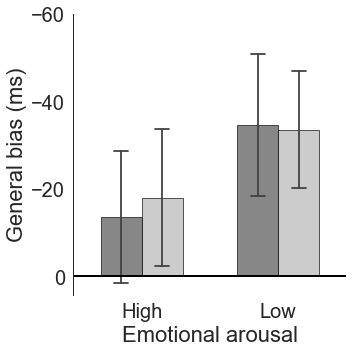

In [23]:
sns.set_theme(style = 'white', font = 'Arial',font_scale = 1.5)

paper_rc = {'lines.linewidth': 1, 'lines.markersize': 2}     
sns.set_context("paper", rc = paper_rc)

colors_list = ['lightcoral','mediumorchid']
colors_list = ['dimgray','silver']
plt.figure(figsize=(6,6))

PlotData_slope = reg_BlockType
PlotData = PlotData_slope.copy() 
PlotData['Intercept'] = PlotData['Intercept']*1000

#ax = sns.boxplot(x='BlockType',y='IPs',hue = 'TrialType',data=PlotData,
#                  hue_order=['High', 'Low'],
#                  palette=colors_list, width=0.75)

#for patch in ax.patches:
#    r, g, b, a = patch.get_facecolor()
#    patch.set_facecolor((r, g, b, .5))

#ax = sns.swarmplot(x='BlockType', y='IPs', hue = 'TrialType',data=PlotData,
#                   hue_order=['High', 'Low'],dodge=True, 
#                   palette=colors_list,size=6,edgecolor="gray", linewidth=0.8)

ax = sns.catplot(x='TrialType',y='Intercept',hue = 'BlockType', kind = 'bar',data=PlotData,
                 hue_order=['Positive', 'Negative'],
                 order=['High', 'Low'],
                 width=0.6,errorbar=('se', 1), legend=False,
                 palette=colors_list, alpha=0.8,aspect=1, capsize=0.1,edgecolor='black')

plt.yticks([0, -20, -40, -60])

plt.axhline(y=0, color='black', linestyle='-',linewidth=2)


plt.xlabel('Emotional arousal', fontsize=22)
ax.set_xticklabels(['High', 'Low'], fontsize=20)
plt.ylabel('General bias (ms)', fontsize=22)
plt.yticks(fontsize=20)

plt.legend([],[], frameon=False)
plt.gca().invert_yaxis()
sns.despine(top=True,right=True,left=False,bottom=True)

plt.tick_params(top=False,bottom=False,left=False,right=False)

plt.tight_layout()
plt.savefig(FigurePath+"/GB_CT_bar.png", dpi=600)
#plt.savefig(FigurePath+"/Res_Error_bar.eps", dpi=600)
plt.show() 



## Serial dependence effect

In [24]:
# replace raw data value 9999 with NaN
rawOneBack = raw.drop(raw[raw['Condition']=='0.0'].index)
rawOneBack['Condition_Prior'] = rawOneBack['Condition'].str.slice(0, 1) 
rawOneBack['Condition_Prior'] = rawOneBack['Condition_Prior'].map({"L": 'PriorLow', "H": 'PriorHigh'})
rawOneBack



,Session,BlockID,BlockType,TrialType,Condition,TimeDur,PictureID,TrialID,RT,PressTimeDur,...,nBack_Time_1,TimeUnRes,nBack_Time,nBack_TrialType,nBack,TimeOutlier,RT_Outlier,SubID,Trials%,Condition_Prior
2,1.0,1.0,Positive,High,LH,0.4,P_26,3.0,1.729167,1.216255,...,1.2,0,1.2,Low,1,0,0,4.0,96.875,PriorLow
3,1.0,1.0,Positive,Low,HL,0.4,L_67,4.0,0.505952,1.375358,...,1.6,0,1.6,High,1,0,0,4.0,96.875,PriorHigh
4,1.0,1.0,Positive,Low,LL,0.0,L_80,5.0,1.117699,0.625146,...,1.6,0,1.6,Low,1,0,0,4.0,96.875,PriorLow
5,1.0,1.0,Positive,High,LH,0.0,P_50,6.0,1.682064,0.672104,...,1.2,0,1.2,Low,1,0,0,4.0,96.875,PriorLow
6,1.0,1.0,Positive,High,HH,0.0,P_32,7.0,1.952601,0.688170,...,1.2,0,1.2,High,1,0,0,4.0,96.875,PriorHigh
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13432,2.0,16.0,Negative,Low,HL,-0.4,L_53,636.0,0.365070,1.296014,...,1.4,0,1.4,High,1,0,0,8.0,98.125,PriorHigh
13433,2.0,16.0,Negative,Low,LL,0.0,L_30,637.0,0.341288,0.927948,...,0.8,0,0.8,Low,1,0,0,8.0,98.125,PriorLow
13434,2.0,16.0,Negative,High,LH,0.0,N_79,638.0,0.306349,1.119951,...,1.2,0,1.2,Low,1,0,0,8.0,98.125,PriorLow
13435,2.0,16.0,Negative,High,HH,-0.4,N_38,639.0,0.376307,1.024027,...,1.2,0,1.2,High,1,0,0,8.0,98.125,PriorHigh


prior duration 0.8
prior duration 1.0
prior duration 1.2
prior duration 1.4
prior duration 1.6


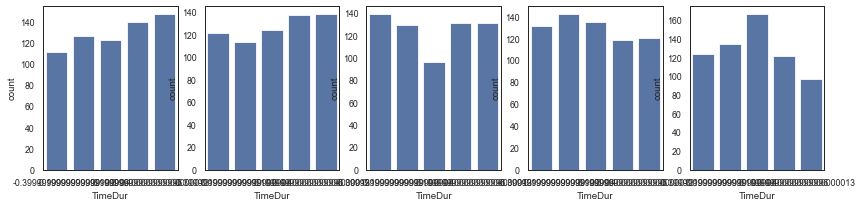

,nBack_Time,TimeDur
0,0.8,0.009631
1,1.0,0.002028
2,1.2,0.001161
3,1.4,-0.003013
4,1.6,-0.007659


In [25]:
# replace raw data value 9999 with NaN
rawOneBack = raw.drop(raw[raw['Condition']=='0.0'].index)
rawOneBack['Condition_Prior'] = rawOneBack['Condition'].str.slice(0, 1) 
rawOneBack['Condition_Prior'] = rawOneBack['Condition_Prior'].map({"L": 'PriorLow', "H": 'PriorHigh'})
rawOneBack

np.sort(rawOneBack['nBack_Time'].unique())

MeanCurrentData = rawOneBack.groupby(['nBack_Time']).agg({'TimeDur':'mean'}).reset_index()

PriorDur = np.sort(rawOneBack['nBack_Time'].unique())
index = 0
fig, ax =plt.subplots(1,5,figsize=(14, 3))

for i in PriorDur:
    print('prior duration',i)
    
    HH = rawOneBack[(rawOneBack["Condition"] == 'HH')]
    plotdataCur = HH.query('nBack_Time == {}'.format(i))
    
    sns.countplot(plotdataCur, x="TimeDur",color = 'b', ax=ax[index])
    index = index+1
    
plt.show()

MeanCurrentData


In [26]:
rawOneBackLMM = rawOneBack 
rawOneBackLMM['BlockType'] = rawOneBackLMM['BlockType'].astype('category')
rawOneBackLMM['TrialType'] = rawOneBackLMM['TrialType'].astype('category')
rawOneBackLMM['Condition_Prior'] = rawOneBackLMM['Condition_Prior'].astype('category')

mPM = (rawOneBackLMM.groupby(['nBack_Time', 'BlockType','TrialType','Condition_Prior', 'SubID'])
       .agg(sPM=('PressTimeError', 'mean'))
       .reset_index())
mPM['nBack_Time'] = mPM['nBack_Time'] - 1.2

mmPM = (mPM.groupby(['nBack_Time', 'BlockType','TrialType','Condition_Prior'])
        .agg(pm=('sPM', 'mean'),
             se=('sPM', lambda x: np.std(x)/np.sqrt(len(x))),
             n=('sPM', 'count'))
        .reset_index())
mod1 = smf.mixedlm("sPM ~ nBack_Time*BlockType*TrialType*Condition_Prior", mPM, groups=mPM["SubID"]).fit(reml=False)
mod1.summary()

/Users/chengsi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                         Mixed Linear Model Regression Results
========================================================================================================================
Model:                                   MixedLM                      Dependent Variable:                      sPM      
No. Observations:                        840                          Method:                                  ML       
No. Groups:                              21                           Scale:                                   0.0042   
Min. group size:                         40                           Log-Likelihood:                          1066.8995
Max. group size:                         40                           Converged:                               Yes      
Mean group size:                         40.0                                                                           
------------------------------------------------------------------------------------------------------------------------
                                                                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------------------------------------
Intercept                                                                     -0.015    0.015 -1.004 0.315 -0.045  0.015
BlockType[T.Positive]                                                         -0.001    0.009 -0.090 0.928 -0.018  0.017
TrialType[T.Low]                                                              -0.014    0.009 -1.542 0.123 -0.031  0.004
Condition_Prior[T.PriorLow]                                                   -0.004    0.009 -0.474 0.635 -0.022  0.013
BlockType[T.Positive]:TrialType[T.Low]                                        -0.004    0.013 -0.302 0.763 -0.029  0.021
BlockType[T.Positive]:Condition_Prior[T.PriorLow]                              0.011    0.013  0.897 0.370 -0.013  0.036
TrialType[T.Low]:Condition_Prior[T.PriorLow]                                  -0.003    0.013 -0.247 0.805 -0.028  0.022
BlockType[T.Positive]:TrialType[T.Low]:Condition_Prior[T.PriorLow]            -0.003    0.018 -0.149 0.882 -0.038  0.032
nBack_Time                                                                     0.186    0.022  8.303 0.000  0.142  0.230
nBack_Time:BlockType[T.Positive]                                              -0.058    0.032 -1.835 0.067 -0.120  0.004
nBack_Time:TrialType[T.Low]                                                   -0.115    0.032 -3.644 0.000 -0.177 -0.053
nBack_Time:Condition_Prior[T.PriorLow]                                        -0.076    0.032 -2.398 0.016 -0.138 -0.014
nBack_Time:BlockType[T.Positive]:TrialType[T.Low]                              0.071    0.045  1.585 0.113 -0.017  0.159
nBack_Time:BlockType[T.Positive]:Condition_Prior[T.PriorLow]                   0.068    0.045  1.509 0.131 -0.020  0.155
nBack_Time:TrialType[T.Low]:Condition_Prior[T.PriorLow]                        0.093    0.045  2.074 0.038  0.005  0.181
nBack_Time:BlockType[T.Positive]:TrialType[T.Low]:Condition_Prior[T.PriorLow] -0.036    0.063 -0.568 0.570 -0.160  0.088
Group Var                                                                      0.004    0.020                           
========================================================================================================================

"""

In [27]:
rawLMM = rawOneBack 
rawLMM['BlockType'] = rawLMM['BlockType'].astype('category')
rawLMM['TrialType'] = rawLMM['TrialType'].astype('category')
mPM = (rawLMM.groupby(['TimeDur', 'BlockType','TrialType', 'SubID'])
       .agg(sPM=('PressTimeError', 'mean'))
       .reset_index())

mPM['TimeDur'] = mPM['TimeDur'] - 1.2
mmPM = (mPM.groupby(['TimeDur', 'BlockType','TrialType'])
        .agg(pm=('sPM', 'mean'),
             se=('sPM', lambda x: np.std(x)/np.sqrt(len(x))),
             n=('sPM', 'count'))
        .reset_index())

contrast_dict = {
    "BlockType": Sum().code_without_intercept([0, 1]),  # Sum contrasts for two-level coding
    "TrialType": Sum().code_without_intercept([0, 1])}   # Sum contrasts for two-level coding

mod1 = smf.mixedlm("sPM ~ TimeDur*C(BlockType, Sum)*C(TrialType, Sum)", mPM, groups = mPM["SubID"]).fit(reml=False)
mod1.summary()

/Users/chengsi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                   Mixed Linear Model Regression Results
===========================================================================================================
Model:                               MixedLM                  Dependent Variable:                  sPM     
No. Observations:                    420                      Method:                              ML      
No. Groups:                          21                       Scale:                               0.0040  
Min. group size:                     20                       Log-Likelihood:                      533.3615
Max. group size:                     20                       Converged:                           Yes     
Mean group size:                     20.0                                                                  
-----------------------------------------------------------------------------------------------------------
                                                                Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                                       -0.589    0.019 -30.703 0.000 -0.627 -0.552
C(BlockType, Sum)[S.Negative]                                   -0.014    0.013  -1.052 0.293 -0.040  0.012
C(TrialType, Sum)[S.High]                                       -0.008    0.013  -0.580 0.562 -0.034  0.018
C(BlockType, Sum)[S.Negative]:C(TrialType, Sum)[S.High]          0.001    0.013   0.077 0.938 -0.025  0.027
TimeDur                                                         -0.471    0.011 -43.370 0.000 -0.493 -0.450
TimeDur:C(BlockType, Sum)[S.Negative]                           -0.011    0.011  -1.020 0.308 -0.032  0.010
TimeDur:C(TrialType, Sum)[S.High]                               -0.014    0.011  -1.277 0.202 -0.035  0.007
TimeDur:C(BlockType, Sum)[S.Negative]:C(TrialType, Sum)[S.High]  0.001    0.011   0.125 0.900 -0.020  0.023
Group Var                                                        0.004    0.021                            
===========================================================================================================

"""

In [28]:
rawOneBackLMM = rawOneBack
rawOneBackLMM['BlockType'] = rawOneBackLMM['BlockType'].astype('category')
rawOneBackLMM['TrialType'] = rawOneBackLMM['TrialType'].astype('category')
rawOneBackLMM['Condition_Prior'] = rawOneBackLMM['Condition_Prior'].astype('category')

mPM = (rawOneBackLMM.groupby(['nBack_Time', 'BlockType','TrialType','Condition_Prior', 'SubID'])
       .agg(sPM=('PressTimeError', 'mean'))
       .reset_index())
mPM['nBack_Time'] = mPM['nBack_Time'] - 1.2

mmPM = (mPM.groupby(['nBack_Time', 'BlockType','TrialType','Condition_Prior'])
        .agg(pm=('sPM', 'mean'),
             se=('sPM', lambda x: np.std(x)/np.sqrt(len(x))),
             n=('sPM', 'count'))
        .reset_index())

contrast_dict = {
    "BlockType": Sum().code_without_intercept([0, 1]),  # Sum contrasts for two-level coding
    "TrialType": Sum().code_without_intercept([0, 1]),   # Sum contrasts for two-level coding
    "Condition_Prior": Sum().code_without_intercept([0, 1])}   # Sum contrasts for two-level coding
        
mod1 = smf.mixedlm("sPM ~ nBack_Time*C(BlockType, Sum)*C(TrialType, Sum)*C(Condition_Prior, Sum)", mPM, 
                   groups = mPM["SubID"]).fit(reml=False)

mod1.summary()


/Users/chengsi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                      Mixed Linear Model Regression Results
==================================================================================================================================================
Model:                                           MixedLM                               Dependent Variable:                               sPM      
No. Observations:                                840                                   Method:                                           ML       
No. Groups:                                      21                                    Scale:                                            0.0042   
Min. group size:                                 40                                    Log-Likelihood:                                   1066.8995
Max. group size:                                 40                                    Converged:                                        Yes      
Mean group size:                                 40.0                                                                                             
--------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                               -0.024    0.014 -1.704 0.088 -0.052  0.004
C(BlockType, Sum)[S.Negative]                                                                           -0.001    0.002 -0.512 0.609 -0.006  0.003
C(TrialType, Sum)[S.High]                                                                                0.009    0.002  4.009 0.000  0.005  0.013
C(Condition_Prior, Sum)[S.PriorHigh]                                                                     0.000    0.002  0.178 0.859 -0.004  0.005
C(BlockType, Sum)[S.Negative]:C(TrialType, Sum)[S.High]                                                 -0.001    0.002 -0.576 0.565 -0.006  0.003
C(BlockType, Sum)[S.Negative]:C(Condition_Prior, Sum)[S.PriorHigh]                                       0.003    0.002  1.120 0.263 -0.002  0.007
C(TrialType, Sum)[S.High]:C(Condition_Prior, Sum)[S.PriorHigh]                                          -0.001    0.002 -0.498 0.619 -0.006  0.003
C(BlockType, Sum)[S.Negative]:C(TrialType, Sum)[S.High]:C(Condition_Prior, Sum)[S.PriorHigh]             0.000    0.002  0.149 0.882 -0.004  0.005
nBack_Time                                                                                               0.115    0.008 14.470 0.000  0.099  0.130
nBack_Time:C(BlockType, Sum)[S.Negative]                                                                -0.001    0.008 -0.137 0.891 -0.017  0.014
nBack_Time:C(TrialType, Sum)[S.High]                                                                     0.021    0.008  2.682 0.007  0.006  0.037
nBack_Time:C(Condition_Prior, Sum)[S.PriorHigh]                                                          0.002    0.008  0.297 0.766 -0.013  0.018
nBack_Time:C(BlockType, Sum)[S.Negative]:C(TrialType, Sum)[S.High]                                       0.013    0.008  1.674 0.094 -0.002  0.029
nBack_Time:C(BlockType, Sum)[S.Negative]:C(Condition_Prior, Sum)[S.PriorHigh]                            0.012    0.008  1.566 0.117 -0.003  0.028
nBack_Time:C(TrialType, Sum)[S.High]:C(Condition_Prior, Sum)[S.PriorHigh]                                0.019    0.008  2.366 0.018  0.003  0.034
nBack_Time:C(BlockType, Sum)[S.Negative]:C(TrialType, Sum)[S.High]:C(Condition_Prior, Sum)[S.PriorHigh]  0.004    0.008  0.568 0.570 -0.011  0.020
Group Var                            

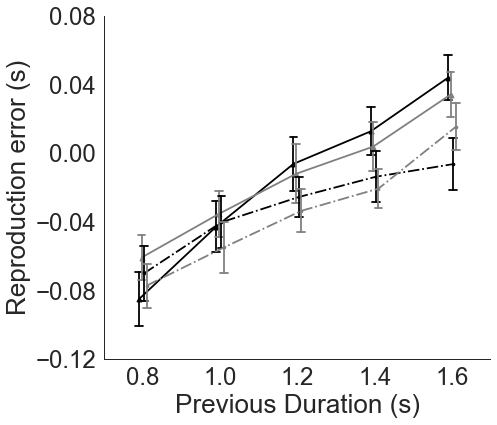

In [29]:
sns.set_theme(style = 'white', font = 'Arial',font_scale = 1.5)

paper_rc = {'lines.linewidth': 1, 'lines.markersize': 2}     
sns.set_context("paper", rc = paper_rc)

#colors_list = ['crimson','darkviolet','yellowgreen','gold']
colors_list = ['#FF7C15','#00A087FF','#FF7C15','#00A087FF']
colors_list = ['dimgray','silver','dimgray','silver']
colors_list = ['#000000','#808080','#000000','#808080']

# data for plotting
PlotData = pd.DataFrame()
PlotData = rawOneBack.groupby(['BlockType','Condition','SubID','nBack_Time']).agg({'PressTimeError':'mean'}).reset_index()


plt.figure(figsize=(7,6))
ax = sns.pointplot(x='nBack_Time',y='PressTimeError',hue="Condition",data=PlotData,
                   hue_order=['HH', 'LH', 'HL', 'LL'],palette=colors_list,
                   linestyles = ['-','-','-.','-.'],markers = ['^','^','.','.'],
                   dodge = True,errorbar=('se', 1),capsize=0.1)

#plt.axhline(y=0, color='k', linestyle='--',linewidth=1)

sns.despine(top=True,right=True,left=False,bottom=False)

plt.yticks([-0.12, -0.08, -0.04,0, 0.04, 0.08])

plt.xlabel('Previous Duration (s)', fontsize=26)
plt.ylabel('Reproduction error (s)', fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

plt.tick_params(top=False,bottom=False,left=False,right=False)

plt.legend(loc='best',fontsize = 16)
plt.gca().get_legend().get_frame().set_linewidth(0)
plt.legend([],[], frameon=False)

plt.tight_layout()
plt.savefig(FigurePath+"/SD_point.png", dpi=600)
plt.show()






### ============= Positive ==============
PlotData_Pos = PlotData.drop(PlotData[PlotData['BlockType']=='Negative'].index)

plt.figure(figsize=(7,6))
ax = sns.pointplot(x='nBack_Time',y='PressTimeError',hue="Condition",data=PlotData_Pos,
                   hue_order=['HH', 'LH', 'HL', 'LL'],palette=colors_list,
                   linestyles = ['-','-','-.','-.'],markers = ['^','^','.','.'],
                   dodge = True,errorbar=('se', 1),capsize=0.1)

#plt.axhline(y=0, color='k', linestyle='--',linewidth=1)

sns.despine(top=True,right=True,left=False,bottom=False)

plt.yticks([-0.12, -0.08, -0.04,0, 0.04, 0.08])

plt.xlabel('Previous Duration (s)', fontsize=26)
plt.ylabel('Reproduction error (s)', fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

plt.tick_params(top=False,bottom=False,left=False,right=False)

plt.legend(loc='best',fontsize = 16)
plt.gca().get_legend().get_frame().set_linewidth(0)
plt.legend([],[], frameon=False)

plt.tight_layout()
plt.savefig(FigurePath+"/Positive_SD_point.png", dpi=600)
#plt.show()


### ============= Negative ==============
PlotData_Neg = PlotData.drop(PlotData[PlotData['BlockType']=='Positive'].index)

plt.figure(figsize=(7,6))
ax = sns.pointplot(x='nBack_Time',y='PressTimeError',hue="Condition",data=PlotData_Neg,
                   hue_order=['HH', 'LH', 'HL', 'LL'],palette=colors_list,
                   linestyles = ['-','-','-.','-.'],markers = ['^','^','.','.'],
                   dodge = True,errorbar=('se', 1),capsize=0.1)

#plt.axhline(y=0, color='k', linestyle='--',linewidth=1)

sns.despine(top=True,right=True,left=False,bottom=False)

plt.yticks([-0.12, -0.08, -0.04,0, 0.04, 0.08])

plt.xlabel('Previous Duration (s)', fontsize=26)
plt.ylabel('Reproduction error (s)', fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

plt.tick_params(top=False,bottom=False,left=False,right=False)

plt.legend(loc='best',fontsize = 16)
plt.gca().get_legend().get_frame().set_linewidth(0)
plt.legend([],[], frameon=False)

plt.tight_layout()
plt.savefig(FigurePath+"/Negative_SD_point.png", dpi=600)
#plt.show()


In [30]:

rawOneBackSD = rawOneBack 
rawOneBackSD['nBack_Time'] = rawOneBackSD['nBack_Time']-1.2

reg_seq = pd.DataFrame(columns=['BlockType','Condition', 'SubID', 'Intercept', 'Slope', 'p'])
for k in rawOneBackSD['BlockType'].unique():
    for i in rawOneBackSD['Condition'].unique():
        for j in rawOneBackSD['SubID'].unique():
            sub = rawOneBackSD.query('BlockType == @k & Condition == @i & SubID == @j')
            model = smf.ols('PressTimeError ~ nBack_Time', data=sub).fit()

            reg_seq = pd.concat([reg_seq, pd.DataFrame({
                'BlockType': k, 
                'Condition': i, 
                'SubID': j, 
                'Intercept': model.params[0], 
                'Slope': model.params[1], 
                'p': model.pvalues[1]
            }, index=[0])], ignore_index=True)
        
reg_seq.head()



,BlockType,Condition,SubID,Intercept,Slope,p
0,Positive,LH,4.0,-0.222830,0.116852,0.293838
1,Positive,LH,16.0,-0.021577,-0.146145,0.119177
2,Positive,LH,14.0,-0.001474,0.038902,0.652102
3,Positive,LH,3.0,-0.042167,0.088649,0.413730
4,Positive,LH,9.0,-0.005055,0.143229,0.107809


In [31]:
reg_seq.groupby(['BlockType','Condition']).agg({'Slope': ['mean', 'sem'], 'Intercept': ['mean', 'sem']}).reset_index().round(3)



BlockType Condition  Slope        Intercept       
                        mean    sem      mean    sem
0  Negative        HH  0.183  0.031    -0.015  0.017
1  Negative        HL  0.070  0.025    -0.029  0.015
2  Negative        LH  0.109  0.021    -0.020  0.016
3  Negative        LL  0.087  0.020    -0.036  0.013
4  Positive        HH  0.125  0.023    -0.017  0.015
5  Positive        HL  0.079  0.027    -0.033  0.018
6  Positive        LH  0.124  0.024    -0.010  0.015
7  Positive        LL  0.132  0.023    -0.032  0.015

In [32]:
anova = pg.rm_anova(data=reg_seq, dv='Slope', within=['BlockType','Condition'], subject='SubID', detailed=True)
anova.round(3)



,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,BlockType,0.000,1,20,0.000,0.065,0.801,0.801,0.000,1.000
1,Condition,0.134,3,60,0.045,5.178,0.003,0.005,0.063,0.860
2,BlockType * Condition,0.060,3,60,0.020,1.458,0.235,0.241,0.029,0.824


In [33]:
reg_seq['Condition_Prior'] = reg_seq['Condition'].str.slice(0, 1) 
reg_seq['Condition_Prior'] = reg_seq['Condition_Prior'].map({"L": 'PriorLow', "H": 'PriorHigh'})
reg_seq['Condition_Current'] = reg_seq['Condition'].str.slice(1, 2) 
reg_seq['Condition_Current'] = reg_seq['Condition_Current'].map({"L": 'CurrLow', "H": 'CurrHigh'})
reg_seq.head()



,BlockType,Condition,SubID,Intercept,Slope,p,Condition_Prior,Condition_Current
0,Positive,LH,4.0,-0.222830,0.116852,0.293838,PriorLow,CurrHigh
1,Positive,LH,16.0,-0.021577,-0.146145,0.119177,PriorLow,CurrHigh
2,Positive,LH,14.0,-0.001474,0.038902,0.652102,PriorLow,CurrHigh
3,Positive,LH,3.0,-0.042167,0.088649,0.413730,PriorLow,CurrHigh
4,Positive,LH,9.0,-0.005055,0.143229,0.107809,PriorLow,CurrHigh


In [34]:
reg_seq.groupby(['BlockType','Condition_Current','Condition_Prior']).agg({'Slope': ['mean', 'sem'], 'Intercept': ['mean', 'sem']}).round(3)


Slope        Intercept       
                                              mean    sem      mean    sem
BlockType Condition_Current Condition_Prior                               
Negative  CurrHigh          PriorHigh        0.183  0.031    -0.015  0.017
                            PriorLow         0.109  0.021    -0.020  0.016
          CurrLow           PriorHigh        0.070  0.025    -0.029  0.015
                            PriorLow         0.087  0.020    -0.036  0.013
Positive  CurrHigh          PriorHigh        0.125  0.023    -0.017  0.015
                            PriorLow         0.124  0.024    -0.010  0.015
          CurrLow           PriorHigh        0.079  0.027    -0.033  0.018
                            PriorLow         0.132  0.023    -0.032  0.015

In [35]:
reg_seq.groupby(['Condition_Current','Condition_Prior']).agg({'Slope': ['mean', 'sem'], 'Intercept': ['mean', 'sem']}).round(3)


Slope        Intercept       
                                    mean    sem      mean    sem
Condition_Current Condition_Prior                               
CurrHigh          PriorHigh        0.154  0.019    -0.016  0.011
                  PriorLow         0.116  0.016    -0.015  0.011
CurrLow           PriorHigh        0.074  0.018    -0.031  0.012
                  PriorLow         0.109  0.015    -0.034  0.010

In [45]:
Data_SD = reg_seq.groupby(['BlockType','Condition_Current','Condition_Prior','SubID']).agg({'Slope':'mean'}).reset_index()

for m in Data_SD['BlockType'].unique():
    for i in Data_SD['Condition_Current'].unique():
        for j in Data_SD['Condition_Prior'].unique():
            sub = Data_SD.query('BlockType == @m & Condition_Current == @i & Condition_Prior == @j')
            stats_sd = pg.ttest(sub['Slope'],0)
            print('============', m, i, j)
            pg.print_table(stats_sd, floatfmt='.3f')
            

============ Negative CurrHigh PriorHigh
    T    dof  alternative      p-val  CI95%          cohen-d      BF10    power
-----  -----  -------------  -------  -----------  ---------  --------  -------
5.892     20  two-sided        0.000  [0.12 0.25]      1.286  2372.023    1.000

============ Negative CurrHigh PriorLow
    T    dof  alternative      p-val  CI95%          cohen-d     BF10    power
-----  -----  -------------  -------  -----------  ---------  -------  -------
5.279     20  two-sided        0.000  [0.07 0.15]      1.152  685.701    0.999

============ Negative CurrLow PriorHigh
    T    dof  alternative      p-val  CI95%          cohen-d    BF10    power
-----  -----  -------------  -------  -----------  ---------  ------  -------
2.787     20  two-sided        0.011  [0.02 0.12]      0.608   4.531    0.755

============ Negative CurrLow PriorLow
    T    dof  alternative      p-val  CI95%          cohen-d     BF10    power
-----  -----  -------------  -------  ---------

In [46]:
anova = pg.anova(data=reg_seq, dv='Slope', between=['BlockType','Condition_Prior','Condition_Current'], ss_type=3,detailed=True,effsize = 'np2')
anova.round(3)



,Source,SS,DF,MS,F,p-unc,np2
0,BlockType,0.000,1.0,0.000,0.030,0.863,0.000
1,Condition_Prior,0.000,1.0,0.000,0.007,0.936,0.000
2,Condition_Current,0.078,1.0,0.078,6.296,0.013,0.038
3,BlockType * Condition_Prior,0.031,1.0,0.031,2.512,0.115,0.015
4,BlockType * Condition_Current,0.025,1.0,0.025,2.033,0.156,0.013
5,Condition_Prior * Condition_Current,0.056,1.0,0.056,4.527,0.035,0.028
6,BlockType * Condition_Prior * Condition_Current,0.004,1.0,0.004,0.292,0.590,0.002
7,Residual,1.980,160.0,0.012,NaN,NaN,NaN


In [47]:
anova = pg.rm_anova(data=reg_seq, dv='Slope', within=['Condition_Prior','Condition_Current'], subject='SubID', detailed=True,effsize = 'np2')
anova.round(3)



,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,Condition_Prior,0.000,1,20,0.000,0.010,0.920,0.920,0.001,1.0
1,Condition_Current,0.039,1,20,0.039,7.356,0.013,0.013,0.269,1.0
2,Condition_Prior * Condition_Current,0.028,1,20,0.028,7.492,0.013,0.013,0.273,1.0


In [48]:
raw_reg_seq = reg_seq

raw_reg_seq['BlockType_Num'] = raw_reg_seq['BlockType'].map({'Negative': 1, 'Positive': 2})
raw_reg_seq['Condition_Current_Num'] = raw_reg_seq['Condition_Current'].map({'CurrLow': 1, 'CurrHigh': 2})
raw_reg_seq['Condition_Prior_Num'] = raw_reg_seq['Condition_Prior'].map({'PriorLow': 1, 'PriorHigh': 2})

Pairedtest_SD = pg.pairwise_tests(data=raw_reg_seq, dv='Slope', within=['Condition_Current_Num','Condition_Prior_Num'], subject='SubID', padjust='bonf', effsize='cohen')

Pairedtest_SD.round(3)


,Contrast,Condition_Current_Num,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen
0,Condition_Current_Num,-,1,2,True,True,-2.712,20.0,two-sided,0.013,NaN,NaN,3.953,-0.633
1,Condition_Prior_Num,-,1,2,True,True,-0.102,20.0,two-sided,0.920,NaN,NaN,0.229,-0.021
2,Condition_Current_Num * Condition_Prior_Num,1,1,2,True,True,2.450,20.0,two-sided,0.024,0.047,bonf,2.485,0.495
3,Condition_Current_Num * Condition_Prior_Num,2,1,2,True,True,-1.659,20.0,two-sided,0.113,0.226,bonf,0.735,-0.423


In [49]:
anova = pg.anova(data=reg_seq, dv='Intercept', between=['BlockType','Condition_Prior','Condition_Current'], ss_type=3,detailed=True,effsize = 'np2')
anova.round(3)

,Source,SS,DF,MS,F,p-unc,np2
0,BlockType,0.000,1.0,0.000,0.034,0.854,0.000
1,Condition_Prior,0.000,1.0,0.000,0.006,0.936,0.000
2,Condition_Current,0.013,1.0,0.013,2.451,0.119,0.015
3,BlockType * Condition_Prior,0.001,1.0,0.001,0.202,0.654,0.001
4,BlockType * Condition_Current,0.000,1.0,0.000,0.037,0.848,0.000
5,Condition_Prior * Condition_Current,0.000,1.0,0.000,0.024,0.877,0.000
6,BlockType * Condition_Prior * Condition_Current,0.000,1.0,0.000,0.012,0.912,0.000
7,Residual,0.821,160.0,0.005,NaN,NaN,NaN


In [50]:
anova = pg.rm_anova(data=reg_seq, dv='Intercept', within=['Condition_Prior','Condition_Current'], subject='SubID', detailed=True,effsize = 'np2')
anova.round(3)



,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,Condition_Prior,0.000,1,20,0.000,0.048,0.829,0.829,0.002,1.0
1,Condition_Current,0.006,1,20,0.006,10.828,0.004,0.004,0.351,1.0
2,Condition_Prior * Condition_Current,0.000,1,20,0.000,0.163,0.691,0.691,0.008,1.0


<Figure size 432x432 with 0 Axes>

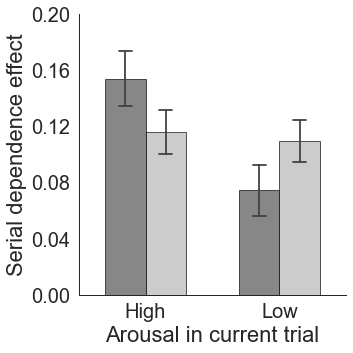

In [36]:
sns.set_theme(style = 'white', font = 'Arial',font_scale = 1.5)

paper_rc = {'lines.linewidth': 1, 'lines.markersize': 2}     
sns.set_context("paper", rc = paper_rc)

colors_list = ['#FF7C15','#00A087FF']
colors_list = ['dimgray','silver']

# data for plotting
PlotData = pd.DataFrame()
PlotData = reg_seq.groupby(['BlockType','Condition_Current','Condition_Prior','SubID']).agg({'Slope':'mean'}).reset_index()

plt.figure(figsize=(6,6))

#ax = sns.boxplot(x='Condition_Current',y='Slope',hue = 'Condition_Prior',data=PlotData_Pos,
#                  hue_order=['PriorHigh', 'PriorLow'],
#                  palette=colors_list, width=0.75)
#for patch in ax.patches:
#    r, g, b, a = patch.get_facecolor()
#    patch.set_facecolor((r, g, b, .5))
#ax = sns.swarmplot(x='Condition_Current', y='Slope', hue = 'Condition_Prior',data=PlotData_Pos,
#                   hue_order=['PriorHigh', 'PriorLow'],dodge=True, 
#                   palette=colors_list,size=6,edgecolor="gray", linewidth=0.8)

ax = sns.catplot(x='Condition_Current',y='Slope',hue = 'Condition_Prior', kind = 'bar',data=PlotData,
                 hue_order=['PriorHigh', 'PriorLow'],
                 width=0.6,errorbar=('se', 1), legend=False,
                 palette=colors_list, alpha=0.8,aspect=1, capsize=0.1,edgecolor='black')

#plt.axhline(y=0, color='k', linestyle='--',linewidth=1)

sns.despine(top=True,right=True,left=False,bottom=False)

plt.yticks([0, 0.04, 0.08, 0.12, 0.16, 0.2])

plt.xlabel('Arousal in current trial', fontsize=22)
ax.set_xticklabels(['High','Low'], fontsize=20)
plt.ylabel('Serial dependence effect', fontsize=22)
plt.yticks(fontsize=20)

plt.tick_params(top=False,bottom=False,left=False,right=False)

plt.legend(loc='best',fontsize = 16)
plt.gca().get_legend().get_frame().set_linewidth(0)
plt.legend([],[], frameon=False)

plt.tight_layout()
plt.savefig(FigurePath+"/SD_bar.png", dpi=600)
plt.show()







### ============= Positive ==============
PlotData_Pos = PlotData.drop(PlotData[PlotData['BlockType']=='Negative'].index)

plt.figure(figsize=(6,6))

#ax = sns.boxplot(x='Condition_Current',y='Slope',hue = 'Condition_Prior',data=PlotData_Pos,
#                  hue_order=['PriorHigh', 'PriorLow'],
#                  palette=colors_list, width=0.75)
#for patch in ax.patches:
#    r, g, b, a = patch.get_facecolor()
#    patch.set_facecolor((r, g, b, .5))
#ax = sns.swarmplot(x='Condition_Current', y='Slope', hue = 'Condition_Prior',data=PlotData_Pos,
#                   hue_order=['PriorHigh', 'PriorLow'],dodge=True, 
#                   palette=colors_list,size=6,edgecolor="gray", linewidth=0.8)

ax = sns.catplot(x='Condition_Current',y='Slope',hue = 'Condition_Prior', kind = 'bar',data=PlotData_Pos,
                 hue_order=['PriorHigh', 'PriorLow'],
                 width=0.6,errorbar=('se', 1), legend=False,
                 palette=colors_list, alpha=0.8,aspect=1, capsize=0.1,edgecolor='black')

#plt.axhline(y=0, color='k', linestyle='--',linewidth=1)

sns.despine(top=True,right=True,left=False,bottom=False)

plt.yticks([0, 0.04, 0.08, 0.12, 0.16, 0.2, 0.24])

plt.xlabel('Arousal in current trial', fontsize=22)
ax.set_xticklabels(['High','Low'], fontsize=20)
plt.ylabel('Serial dependence index', fontsize=22)
plt.yticks(fontsize=20)

plt.tick_params(top=False,bottom=False,left=False,right=False)

plt.legend(loc='best',fontsize = 16)
plt.gca().get_legend().get_frame().set_linewidth(0)
plt.legend([],[], frameon=False)

plt.tight_layout()
plt.savefig(FigurePath+"/Positive_SD_bar.png", dpi=600)
plt.show()


### ============= Negative ==============
PlotData_Neg = PlotData.drop(PlotData[PlotData['BlockType']=='Positive'].index)

plt.figure(figsize=(6,6))

#ax = sns.boxplot(x='Condition_Current',y='Slope',hue = 'Condition_Prior',data=PlotData_Neg,
#                  hue_order=['PriorHigh', 'PriorLow'],
#                  palette=colors_list, width=0.75)
#for patch in ax.patches:
#    r, g, b, a = patch.get_facecolor()
#    patch.set_facecolor((r, g, b, .5))
#ax = sns.swarmplot(x='Condition_Current', y='Slope', hue = 'Condition_Prior',data=PlotData_Neg,
#                   hue_order=['PriorHigh', 'PriorLow'],dodge=True, 
#                   palette=colors_list,size=6,edgecolor="gray", linewidth=0.8)

ax = sns.catplot(x='Condition_Current',y='Slope',hue = 'Condition_Prior', kind = 'bar',data=PlotData_Neg,
                 hue_order=['PriorHigh', 'PriorLow'],
                 width=0.6,errorbar=('se', 1), legend=False,
                 palette=colors_list, alpha=0.8,aspect=1, capsize=0.1,edgecolor='black')

#plt.axhline(y=0, color='k', linestyle='--',linewidth=1)

sns.despine(top=True,right=True,left=False,bottom=False)

plt.yticks([0, 0.04, 0.08, 0.12, 0.16, 0.2, 0.24])

plt.xlabel('Arousal in current trial', fontsize=22)
ax.set_xticklabels(['High','Low'], fontsize=20)
plt.ylabel('Serial dependence index', fontsize=22)
plt.yticks(fontsize=20)

plt.tick_params(top=False,bottom=False,left=False,right=False)

plt.legend(loc='best',fontsize = 16)
plt.gca().get_legend().get_frame().set_linewidth(0)
plt.legend([],[], frameon=False)

plt.tight_layout()
plt.savefig(FigurePath+"/Negative_SD_bar.png", dpi=600)
plt.show()

<Figure size 432x432 with 0 Axes>

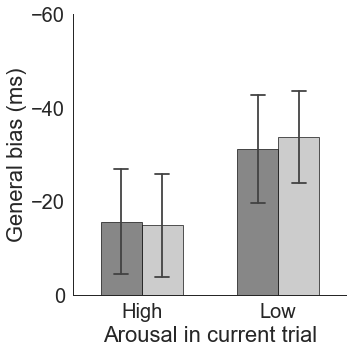

In [37]:
sns.set_theme(style = 'white', font = 'Arial',font_scale = 1.5)

paper_rc = {'lines.linewidth': 1, 'lines.markersize': 2}     
sns.set_context("paper", rc = paper_rc)

colors_list = ['#FF7C15','#00A087FF']
colors_list = ['dimgray','silver']

# data for plotting
PlotData = pd.DataFrame()
PlotData = reg_seq.groupby(['BlockType','Condition_Current','Condition_Prior','SubID']).agg({'Intercept':'mean'}).reset_index()
PlotData['Intercept'] = PlotData['Intercept']*1000

plt.figure(figsize=(6,6))

#ax = sns.boxplot(x='Condition_Current',y='Slope',hue = 'Condition_Prior',data=PlotData_Pos,
#                  hue_order=['PriorHigh', 'PriorLow'],
#                  palette=colors_list, width=0.75)
#for patch in ax.patches:
#    r, g, b, a = patch.get_facecolor()
#    patch.set_facecolor((r, g, b, .5))
#ax = sns.swarmplot(x='Condition_Current', y='Slope', hue = 'Condition_Prior',data=PlotData_Pos,
#                   hue_order=['PriorHigh', 'PriorLow'],dodge=True, 
#                   palette=colors_list,size=6,edgecolor="gray", linewidth=0.8)

ax = sns.catplot(x='Condition_Current',y='Intercept',hue = 'Condition_Prior', kind = 'bar',data=PlotData,
                 hue_order=['PriorHigh', 'PriorLow'],
                 width=0.6,errorbar=('se', 1), legend=False,
                 palette=colors_list, alpha=0.8,aspect=1, capsize=0.1,edgecolor='black')

#plt.axhline(y=0, color='k', linestyle='--',linewidth=1)

sns.despine(top=True,right=True,left=False,bottom=False)

plt.yticks([0, -20, -40, -60])
plt.gca().invert_yaxis()
plt.xlabel('Arousal in current trial', fontsize=22)
ax.set_xticklabels(['High','Low'], fontsize=20)
plt.ylabel('General bias (ms)', fontsize=22)
plt.yticks(fontsize=20)

plt.tick_params(top=False,bottom=False,left=False,right=False)

plt.legend(loc='best',fontsize = 16)
plt.gca().get_legend().get_frame().set_linewidth(0)
plt.legend([],[], frameon=False)

plt.tight_layout()
plt.savefig(FigurePath+"/GB_bar.png", dpi=600)
plt.show()




## Relation between the central tendency and sequential dependence

We have the central tendency effect stored in the dataframe `reg` and the sequential effect in `reg_seq`. Let's merge them and see if there is any relation between the two effects.

In [57]:
reg_ct['cdi'] = -reg_ct['Slope']
reg_seq.rename(columns={'Slope': 'sdi'}, inplace=True)

tdi = pd.merge(reg_ct, reg_seq, on=['Condition', 'SubID'], how='inner')[['Condition', 'SubID', 'cdi', 'sdi']]
tdi.head()



,Condition,SubID,cdi,sdi
0,LH,4.0,0.740231,0.116852
1,LH,4.0,0.740231,-0.065556
2,LH,4.0,0.603719,0.116852
3,LH,4.0,0.603719,-0.065556
4,LH,16.0,0.430280,-0.146145


Text(0.5, 1.0, 'Central tendency index vs. Sequential dependence index')

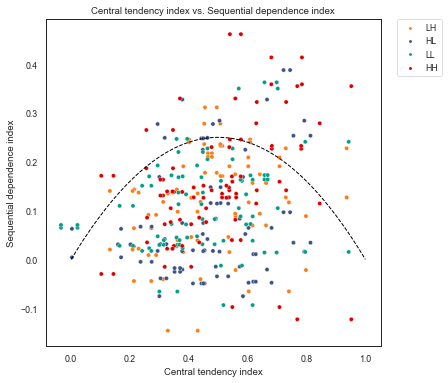

In [58]:
# scatter plot of cdi vs. sdi, color separate by Condition
sns.set_theme(style = 'white', font = 'Arial',font_scale = 1.5)

paper_rc = {'lines.linewidth': 1, 'lines.markersize': 2}     
sns.set_context("paper", rc = paper_rc)

plt.figure(figsize=(6,6))

colors_list = ['#FF7C15','#3C5488FF','#00A087FF','#DC0000FF']


sns.scatterplot(x='cdi', y='sdi', hue='Condition', data=tdi,palette=colors_list,s=18) #hue_order=['TT', 'DT'],
# add a curve of s = cdi*(1-cdi) to the plot
x = np.linspace(0, 1, 100)
y = x*(1-x)
plt.plot(x, y, color='black', linestyle='--')
# add x label "Central tendency index" and y label "Sequential dependence index"
plt.xlabel('Central tendency index')
plt.ylabel('Sequential dependence index')
# move legend to the right
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# add a title "Central tendency index vs. Sequential dependence index"
plt.title('Central tendency index vs. Sequential dependence index')
# save the figure to subfolger figs


In [59]:
def plotRaster(data, title='', vmin=-0.3, vmax=0.3, bw_threshold=0.21, ax=None, cbar=True, fontsize=8, cmap='RdBu_r', annotated=False): #RdBu_r parula
    '''
    Plot a raster of 5X5 size

    Parameters
    ----------
    data : 5X5 dimensional numpy array
    title: string
        Text to be appended to figure top
    vmin, vmax: numbers
        Minimun and Maximun values to set the colormap
    bw_threshold: integer
        Absolute value where annotated text must change from black to white
    ax: Matplotlib axes
        It's optional to assign a matplitlib axes to this function

    Returns
    -------
    Matplotlib axes
    '''

    if ax is None: # Check wether an axes was assigned or not
        fig, ax = plt.subplots() # Create figure
        fig.set_size_inches((6,6)) # Set a size
        
       
    img = ax.imshow(data, cmap=cmap, origin='lower', vmin=vmin, vmax=vmax,
                    aspect='equal') # Plot image
    if annotated:
        for l in range(5):
            for k in range(5):
                num = round(data[l,k],2)
                # Draw annotated values to the raster
                ax.text(k,l,num, horizontalalignment='center', verticalalignment='center', color='white' if abs(num)>=bw_threshold else 'black', fontsize=fontsize)

    ax.set_xticklabels(['',  0.8, 1.0, 1.2, 1.4, 1.6], fontsize=18) # Set the x ticks values            
    ax.set_yticklabels(['',  0.8, 1.0, 1.2, 1.4, 1.6], fontsize=18) # Set the y ticks values
    
    ax.set_xlabel('Current Duration (s)', fontsize=20) # Set the x labes
    ax.set_ylabel('Previous Duration (s)', fontsize=20) # Set the y labes

    ax.set_xticks(np.arange(6)-.5, minor=True) # Set the x ticks range to center the labels
    ax.set_yticks(np.arange(6)-.5, minor=True) # Set the y ticks range to center the labels
    ax.grid(which="minor", color="w", linestyle='-', linewidth=0) # Show grid
    ax.tick_params(which="minor", bottom=False, left=False) # Hide the minot ticks marker

    for edges, spine in ax.spines.items():
        spine.set_visible(False) # Hide borders
    
    ax.set_title(title, fontsize=20) # Set figure title

    if cbar:
        cax = fig.add_axes([.92, .4, 0.02, 0.25]) # Create a new axes for color bar
        cb = fig.colorbar(img, cax=cax, extend='both', orientation='vertical') # Plot the color bar
        cb.ax.tick_params(labelsize=14) # Set color bar font size
        return ax
    
    return ax, img

In [60]:
raster_Time = rawOneBack.groupby(['BlockType','Condition','SubID','TimeDur','nBack_Time']).agg({'PressTimeError':'mean'}).reset_index()
raster_Time
#raster_Time.to_excel(ResultPath+"/raster_Time.xlsx")   
print(len(raster_Time))

MeanValues = rawOneBack.groupby(['BlockType','Condition','SubID','TimeDur']).agg({'PressTimeError':'mean'}).reset_index()


AllsubData = pd.DataFrame()
for m in raster_Time['BlockType'].unique():
    for i in raster_Time['Condition'].unique():
        for j in raster_Time['SubID'].unique():
            for k in raster_Time['TimeDur'].unique():
                sub = rawOneBack.query('BlockType == @m & Condition == @i & SubID == @j & TimeDur == @k')
                #print(sub['nBack_Time'].unique())
                MissingValue = list(set([0.8, 1.0, 1.2, 1.4, 1.6])^set(sub['nBack_Time'].unique()))
                #print(MissingValue)
                #print(len(MissingValue))
                if len(MissingValue)>0:
                    raster_fill = []
                    for l in MissingValue:
                        #print(l)
                        MeanFill = MeanValues.query('BlockType == @m & Condition == @i & SubID == @j & TimeDur == @k')['PressTimeError']
                        #print(MeanFill)
                        raster_fill = [m, i, j, k, l, MeanFill]
                        raster_fill = pd.DataFrame(raster_fill).T
                        AllsubData = pd.concat([AllsubData, raster_fill])
                        #print(raster_fill)

AllsubData.columns = ['BlockType', 'Condition', 'SubID', 'TimeDur', 'nBack_Time', 'PressTimeError']


raster_Time = pd.concat([raster_Time, AllsubData])

raster_Time = raster_Time.groupby(['BlockType','Condition','SubID','TimeDur','nBack_Time']).agg({'PressTimeError':'mean'}).reset_index()
raster_Time.to_excel(DataPath+"/raster_Time_new.xlsx") 

print(len(raster_Time))

4085


<ipython-input-60-e104a8218eaf>:36: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.7' currently installed).
  raster_Time.to_excel(DataPath+"/raster_Time_new.xlsx")


4200


<ipython-input-59-7f43f6f9df8f>:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['',  0.8, 1.0, 1.2, 1.4, 1.6], fontsize=18) # Set the x ticks values
<ipython-input-59-7f43f6f9df8f>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['',  0.8, 1.0, 1.2, 1.4, 1.6], fontsize=18) # Set the y ticks values


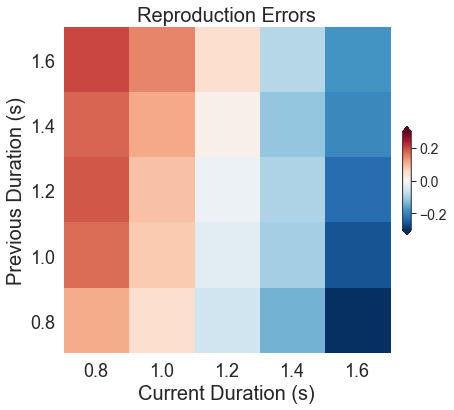

In [61]:

#raster_Time_Pos = raster_Time.drop(raster_Time[raster_Time['BlockType']=='Negative'].index)

raster_HH = raster_Time.loc[raster_Time['Condition']=='HH']

raster_HH = raster_HH.groupby(['SubID','TimeDur','nBack_Time'])['PressTimeError'].mean().values #

raster_HH = np.reshape(raster_HH, (-1,5,5)).mean(axis=0).T # Reshape into a 5X5 matrix
raster_HH = raster_HH.astype(float)
raster_HH

_ = plotRaster(raster_HH, 'Reproduction Errors', fontsize=12, cbar=True) # plot the raster
#plt.tight_layout()
#plt.savefig(FigurePath+"/Reproduction_SD_CT_rasterplot_HH.png",bbox_inches='tight', pad_inches=0.1,dpi=600)
plt.savefig(FigurePath+"/Reproduction_SD_CT_rasterplot_test.png",bbox_inches='tight', pad_inches=0.1,dpi=600)


<ipython-input-59-7f43f6f9df8f>:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['',  0.8, 1.0, 1.2, 1.4, 1.6], fontsize=18) # Set the x ticks values
<ipython-input-59-7f43f6f9df8f>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['',  0.8, 1.0, 1.2, 1.4, 1.6], fontsize=18) # Set the y ticks values


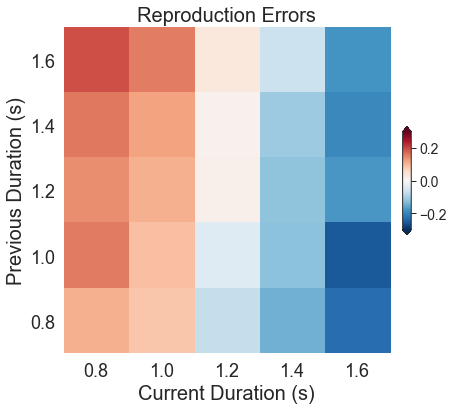

In [62]:
#raster_Time_Pos = raster_Time.drop(raster_Time[raster_Time['BlockType']=='Negative'].index)

raster_LH = raster_Time.loc[raster_Time['Condition']=='LH']

raster_LH = raster_LH.groupby(['SubID','TimeDur','nBack_Time'])['PressTimeError'].mean().values #

raster_LH = np.reshape(raster_LH, (-1,5,5)).mean(axis=0).T # Reshape into a 5X5 matrix
raster_LH = raster_LH.astype(float)
raster_LH

_ = plotRaster(raster_LH, 'Reproduction Errors', fontsize=12, cbar=True) # plot the raster
#plt.tight_layout()
plt.savefig(FigurePath+"/Reproduction_SD_CT_rasterplot_LH.png",bbox_inches='tight', pad_inches=0.1,dpi=600)


<ipython-input-59-7f43f6f9df8f>:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['',  0.8, 1.0, 1.2, 1.4, 1.6], fontsize=18) # Set the x ticks values
<ipython-input-59-7f43f6f9df8f>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['',  0.8, 1.0, 1.2, 1.4, 1.6], fontsize=18) # Set the y ticks values


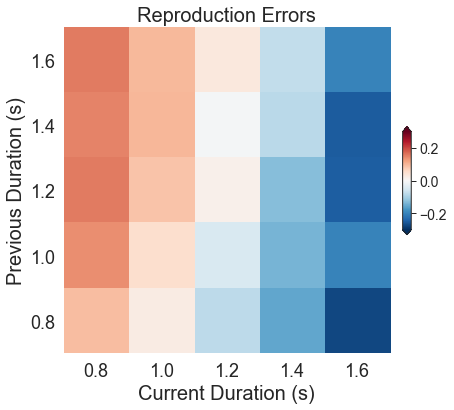

In [63]:
#raster_Time_Pos = raster_Time.drop(raster_Time[raster_Time['BlockType']=='Negative'].index)

raster_HL = raster_Time.loc[raster_Time['Condition']=='HL']

raster_HL = raster_HL.groupby(['SubID','TimeDur','nBack_Time'])['PressTimeError'].mean().values #

raster_HL = np.reshape(raster_HL, (-1,5,5)).mean(axis=0).T # Reshape into a 5X5 matrix
raster_HL = raster_HL.astype(float)
raster_HL

_ = plotRaster(raster_HL, 'Reproduction Errors', fontsize=12, cbar=True) # plot the raster
#plt.tight_layout()
plt.savefig(FigurePath+"/Reproduction_SD_CT_rasterplot_HL.png",bbox_inches='tight', pad_inches=0.1,dpi=600)


<ipython-input-59-7f43f6f9df8f>:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['',  0.8, 1.0, 1.2, 1.4, 1.6], fontsize=18) # Set the x ticks values
<ipython-input-59-7f43f6f9df8f>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['',  0.8, 1.0, 1.2, 1.4, 1.6], fontsize=18) # Set the y ticks values


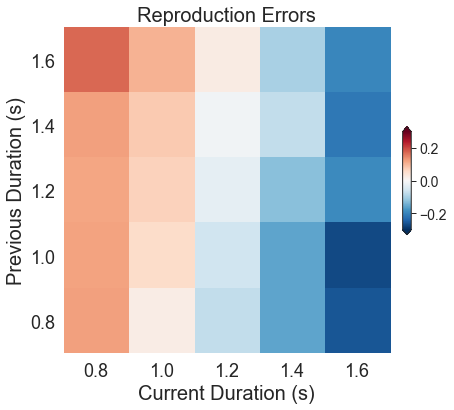

In [64]:
#raster_Time_Pos = raster_Time.drop(raster_Time[raster_Time['BlockType']=='Negative'].index)

raster_LL = raster_Time.loc[raster_Time['Condition']=='LL']

raster_LL = raster_LL.groupby(['SubID','TimeDur','nBack_Time'])['PressTimeError'].mean().values #

raster_LL = np.reshape(raster_LL, (-1,5,5)).mean(axis=0).T # Reshape into a 5X5 matrix
raster_LL = raster_LL.astype(float)
raster_LL

_ = plotRaster(raster_LL, 'Reproduction Errors', fontsize=12, cbar=True) # plot the raster
#plt.tight_layout()
plt.savefig(FigurePath+"/Reproduction_SD_CT_rasterplot_LL.png",bbox_inches='tight', pad_inches=0.1,dpi=600)


## Negative

<ipython-input-59-7f43f6f9df8f>:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['',  0.8, 1.0, 1.2, 1.4, 1.6], fontsize=18) # Set the x ticks values
<ipython-input-59-7f43f6f9df8f>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['',  0.8, 1.0, 1.2, 1.4, 1.6], fontsize=18) # Set the y ticks values


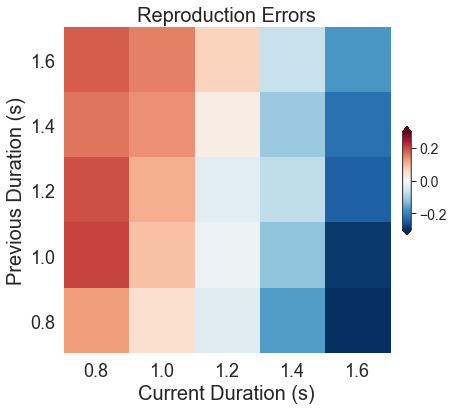

In [65]:

raster_Time_Neg = raster_Time.drop(raster_Time[raster_Time['BlockType']=='Positive'].index)

raster_HH = raster_Time_Neg.loc[raster_Time['Condition']=='HH']

raster_HH = raster_HH.groupby(['SubID','TimeDur','nBack_Time'])['PressTimeError'].mean().values #

raster_HH = np.reshape(raster_HH, (-1,5,5)).mean(axis=0).T # Reshape into a 5X5 matrix
raster_HH = raster_HH.astype(float)
raster_HH

_ = plotRaster(raster_HH, 'Reproduction Errors', fontsize=12, cbar=True) # plot the raster
#plt.tight_layout()
#plt.savefig(FigurePath+"/Exp2_Reproduction_SD_CT_rasterplot_TT.png",bbox_inches='tight', pad_inches=0.1,dpi=600)


<ipython-input-59-7f43f6f9df8f>:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['',  0.8, 1.0, 1.2, 1.4, 1.6], fontsize=18) # Set the x ticks values
<ipython-input-59-7f43f6f9df8f>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['',  0.8, 1.0, 1.2, 1.4, 1.6], fontsize=18) # Set the y ticks values


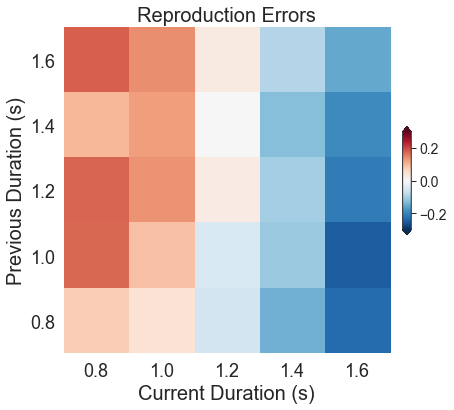

In [66]:
raster_Time_Neg = raster_Time.drop(raster_Time[raster_Time['BlockType']=='Positive'].index)

raster_LH = raster_Time_Neg.loc[raster_Time['Condition']=='LH']

raster_LH = raster_LH.groupby(['SubID','TimeDur','nBack_Time'])['PressTimeError'].mean().values #

raster_LH = np.reshape(raster_LH, (-1,5,5)).mean(axis=0).T # Reshape into a 5X5 matrix
raster_LH = raster_LH.astype(float)
raster_LH

_ = plotRaster(raster_LH, 'Reproduction Errors', fontsize=12, cbar=True) # plot the raster
#plt.tight_layout()
#plt.savefig(FigurePath+"/Exp2_Reproduction_SD_CT_rasterplot_TT.png",bbox_inches='tight', pad_inches=0.1,dpi=600)


<ipython-input-59-7f43f6f9df8f>:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['',  0.8, 1.0, 1.2, 1.4, 1.6], fontsize=18) # Set the x ticks values
<ipython-input-59-7f43f6f9df8f>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['',  0.8, 1.0, 1.2, 1.4, 1.6], fontsize=18) # Set the y ticks values


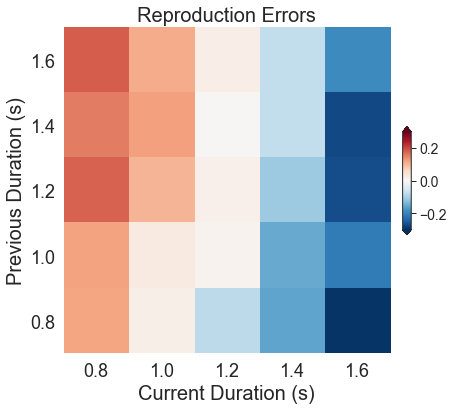

In [67]:
raster_Time_Neg = raster_Time.drop(raster_Time[raster_Time['BlockType']=='Positive'].index)

raster_HL = raster_Time_Neg.loc[raster_Time['Condition']=='HL']

raster_HL = raster_HL.groupby(['SubID','TimeDur','nBack_Time'])['PressTimeError'].mean().values #

raster_HL = np.reshape(raster_HL, (-1,5,5)).mean(axis=0).T # Reshape into a 5X5 matrix
raster_HL = raster_HL.astype(float)
raster_HL

_ = plotRaster(raster_HL, 'Reproduction Errors', fontsize=12, cbar=True) # plot the raster
#plt.tight_layout()
#plt.savefig(FigurePath+"/Exp2_Reproduction_SD_CT_rasterplot_TT.png",bbox_inches='tight', pad_inches=0.1,dpi=600)


<ipython-input-59-7f43f6f9df8f>:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['',  0.8, 1.0, 1.2, 1.4, 1.6], fontsize=18) # Set the x ticks values
<ipython-input-59-7f43f6f9df8f>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['',  0.8, 1.0, 1.2, 1.4, 1.6], fontsize=18) # Set the y ticks values


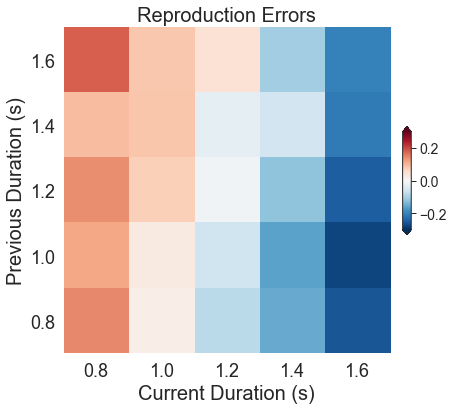

In [68]:
raster_Time_Neg = raster_Time.drop(raster_Time[raster_Time['BlockType']=='Positive'].index)

raster_LL = raster_Time_Neg.loc[raster_Time['Condition']=='LL']

raster_LL = raster_LL.groupby(['SubID','TimeDur','nBack_Time'])['PressTimeError'].mean().values #

raster_LL = np.reshape(raster_LL, (-1,5,5)).mean(axis=0).T # Reshape into a 5X5 matrix
raster_LL = raster_LL.astype(float)
raster_LL

_ = plotRaster(raster_LL, 'Reproduction Errors', fontsize=12, cbar=True) # plot the raster
#plt.tight_layout()
#plt.savefig(FigurePath+"/Exp2_Reproduction_SD_CT_rasterplot_TT.png",bbox_inches='tight', pad_inches=0.1,dpi=600)


In [53]:
DataPath_file = glob.glob(DataPath+"*.csv")
DataPath_file

['/Users/chengsi/Desktop/SerialBias/E8_TimeEmotion_NCP/E_4_Data_Analysis/Results/AllSubCleanBackData4.csv',
 '/Users/chengsi/Desktop/SerialBias/E8_TimeEmotion_NCP/E_4_Data_Analysis/Results/AllSubCleanBackData2.csv',
 '/Users/chengsi/Desktop/SerialBias/E8_TimeEmotion_NCP/E_4_Data_Analysis/Results/AllSubCleanBackData3.csv',
 '/Users/chengsi/Desktop/SerialBias/E8_TimeEmotion_NCP/E_4_Data_Analysis/Results/AllSubCleanBackData1.csv',
 '/Users/chengsi/Desktop/SerialBias/E8_TimeEmotion_NCP/E_4_Data_Analysis/Results/AllSubCleanBackData-1.csv',
 '/Users/chengsi/Desktop/SerialBias/E8_TimeEmotion_NCP/E_4_Data_Analysis/Results/AllSubCleanBackData-2.csv']

In [54]:
def LoadData(DataPath):
    
    raw = pd.read_csv(DataPath)
    raw = raw.replace(9999, np.nan)
    raw = raw.drop(columns=['Unnamed: 0'])

    raw['index'] = list(range(0,len(raw),1))
    raw = raw.set_index('index')
    raw = raw.reset_index(drop=True)

    #raw = raw.dropna()
    raw = raw.query('TimeOutlier != 1 & RT_Outlier != 1 & TimeUnRes != 1')
    raw = raw.query('PressTimeError != 9999')

        
    return raw

In [55]:
'Part 4 ========================Subjects============================='
def AddSubjectData(path_csv):
    AllsubData = pd.DataFrame()
    for i in path_csv:
        rawData = LoadData(i)
        AllsubData = pd.concat([AllsubData, rawData])
    return AllsubData

In [56]:
AllBackData_raw = AddSubjectData(DataPath_file)

AllBackData_raw = AllBackData_raw.sort_values(by=['nBack','SubID','TrialID'])
#AllBackData_raw= AllBackData_raw.drop(AllBackData_raw[AllBackData_raw['BlockType']=='Positive'].index)

AllBackData = AllBackData_raw.dropna()
AllBackData = AllBackData.query('nBack != 4 & nBack != 9 & nBack != 10')
AllBackData

print(AllBackData['SubID'].unique())

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21.]


In [57]:
reg_seq_con = pd.DataFrame(columns=['nBack', 'TrialType','nBack_TrialType','SubID', 'Intercept', 'Slope', 'p'])
for k in AllBackData['nBack'].unique():
    for i in AllBackData['TrialType'].unique():
        for j in AllBackData['nBack_TrialType'].unique():
            for m in AllBackData['SubID'].unique():
                sub = AllBackData.query('nBack == @k & TrialType == @i & nBack_TrialType == @j & SubID == @m')
                model = smf.ols('PressTimeError ~ nBack_Time', data=sub).fit()
                reg_seq_con = pd.concat([reg_seq_con, pd.DataFrame({'nBack': k,'TrialType': i,'nBack_TrialType': j, 'SubID': m, 'Intercept': model.params[0], 'Slope': model.params[1], 'p': model.pvalues[1]}, index=[0])], ignore_index=True)
reg_seq_con.head()


,nBack,TrialType,nBack_TrialType,SubID,Intercept,Slope,p
0,-2,High,Low,1.0,0.025994,-0.044853,0.507124
1,-2,High,Low,2.0,-0.076364,0.049202,0.358458
2,-2,High,Low,3.0,-0.005323,-0.069955,0.323984
3,-2,High,Low,4.0,-0.159012,-0.039601,0.602802
4,-2,High,Low,5.0,0.115824,-0.024056,0.738988


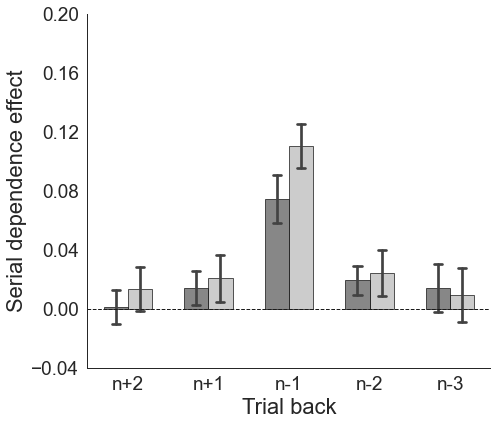

In [58]:
sns.set_theme(style = 'white', font = 'Arial')
paper_rc = {'lines.linewidth': 1.5, 'lines.markersize': 3}     
sns.set_context("paper", rc = paper_rc)
plt.figure(figsize=(7,6))

colors_list = ['#FF7C15','#00A087FF']
colors_list = ['dimgray','silver']

reg_seq_con_CurLow = reg_seq_con.drop(reg_seq_con[reg_seq_con['TrialType']=='High'].index)

PlotData = reg_seq_con_CurLow.groupby(['nBack','SubID','nBack_TrialType']).agg({'Slope':'mean'}).reset_index()

ax = sns.barplot(x='nBack',y='Slope',hue="nBack_TrialType",data=PlotData,
                 hue_order=['High','Low'], palette=colors_list,
                 dodge = True,errorbar=('se', 1),capsize=0.1,
                 width=0.6, alpha=0.8,edgecolor='black') 

plt.yticks([ -0.04, 0.0, 0.04, 0.08, 0.12, 0.16, 0.20])
plt.axhline(y=0, color='k', linestyle='--',linewidth=1)

plt.xlabel('Trial back', fontsize=22)
plt.ylabel('Serial dependence effect', fontsize=22)
ax.set_xticklabels(['n+2','n+1','n-1','n-2','n-3'])

plt.xticks(fontsize=19)
plt.yticks(fontsize=19)

sns.despine(top=True,right=True,left=False,bottom=False)

# remove legend box
plt.legend(loc='best',fontsize = 20)
plt.gca().get_legend().get_frame().set_linewidth(0)
plt.legend([],[], frameon=False)
plt.tick_params(top=False,bottom=False,left=False,right=False)

plt.tight_layout()
plt.savefig(FigurePath+"/nBack_currentLow.png", dpi=600)
#plt.savefig(FigurePath+"/SerialDep_Feedback_pointplot.eps", dpi=600)
plt.show()


In [59]:
reg_seq_con_CurLow.groupby(['nBack','SubID','nBack_TrialType']).agg({ 'Slope': ['mean', 'sem'],'Intercept': ['mean', 'sem']}).reset_index()
reg_seq_con_CurLow = reg_seq_con_CurLow.sort_values(by=['nBack','SubID','nBack_TrialType'])
reg_seq_con_CurLow



,nBack,TrialType,nBack_TrialType,SubID,Intercept,Slope,p
63,-2,Low,High,1.0,-0.075221,0.013909,0.822253
42,-2,Low,Low,1.0,0.032156,-0.077042,0.411264
64,-2,Low,High,2.0,-0.091936,0.060261,0.170096
43,-2,Low,Low,2.0,0.055853,-0.053545,0.425267
65,-2,Low,High,3.0,0.011338,-0.104368,0.066919
...,...,...,...,...,...,...,...
396,3,Low,Low,19.0,-0.157988,0.104267,0.043018
418,3,Low,High,20.0,0.024082,0.060781,0.226964
397,3,Low,Low,20.0,0.185927,-0.083612,0.187740
419,3,Low,High,21.0,0.057537,-0.036729,0.529433


In [60]:
reg_seq_con_CurLow.groupby(['nBack','nBack_TrialType']).agg({'Slope': ['mean', 'sem'],'Intercept': ['mean', 'sem']}).reset_index().round(3)


nBack nBack_TrialType  Slope        Intercept       
                          mean    sem      mean    sem
0    -2            High  0.001  0.011    -0.034  0.016
1    -2             Low  0.013  0.015    -0.048  0.022
2    -1            High  0.014  0.012    -0.049  0.019
3    -1             Low  0.020  0.016    -0.059  0.026
4     1            High  0.074  0.016    -0.120  0.028
5     1             Low  0.110  0.015    -0.166  0.022
6     2            High  0.019  0.010    -0.058  0.015
7     2             Low  0.024  0.016    -0.056  0.020
8     3            High  0.014  0.016    -0.047  0.022
9     3             Low  0.009  0.018    -0.046  0.022

In [61]:
for k in sorted(reg_seq_con_CurLow['nBack'].unique()):
    print('======================================= nBack =========================================:',k)
    sub = reg_seq_con_CurLow.query('nBack == @k').groupby(['SubID','nBack_TrialType']).agg({'Slope': 'mean'}).reset_index()
    print('---- Prior Low ----:')
    Same_seq_stats = pg.ttest(sub[sub['nBack_TrialType']=='Low']['Slope'],0)
    pg.print_table(Same_seq_stats, floatfmt='.5f')
    
    print('---- Prior High ----:')
    Different_seq_stats = pg.ttest(sub[sub['nBack_TrialType']=='High']['Slope'],0)
    pg.print_table(Different_seq_stats, floatfmt='.5f')   
    
    print('---- Prior Low vs Prior High ----:')
    Same_Diff_seq_stats = pg.pairwise_tests(data=sub, dv='Slope', within='nBack_TrialType', subject='SubID',  effsize='cohen')
    pg.print_table(Same_Diff_seq_stats, floatfmt='.5f')    
    
    

======================================= nBack =========================================: -2
---- Prior Low ----:
      T    dof  alternative      p-val  CI95%            cohen-d     BF10    power
-------  -----  -------------  -------  -------------  ---------  -------  -------
0.90483     20  two-sided      0.37633  [-0.02  0.04]    0.19745  0.32800  0.13849

---- Prior High ----:
      T    dof  alternative      p-val  CI95%            cohen-d     BF10    power
-------  -----  -------------  -------  -------------  ---------  -------  -------
0.06651     20  two-sided      0.94763  [-0.02  0.02]    0.01451  0.22800  0.05046

---- Prior Low vs Prior High ----:

POST HOC TESTS

Contrast         A     B    Paired    Parametric           T       dof  alternative      p-unc     BF10     cohen
---------------  ----  ---  --------  ------------  --------  --------  -------------  -------  -------  --------
nBack_TrialType  High  Low  True      True          -0.66108  20.00000  two-sided    

In [62]:
pvals = [0.37633, 0.22135, 0.00000, 0.13476, 0.62899]
reject, pvals_corr = pg.multicomp(pvals, method='bonf')
print(reject, pvals_corr)

[False False  True False False] [1.     1.     0.     0.6738 1.    ]


In [63]:
pvals = [0.94763, 0.24224, 0.00020, 0.06932, 0.39332]
reject, pvals_corr = pg.multicomp(pvals, method='bonf')
print(reject, pvals_corr)

[False False  True False False] [1.     1.     0.001  0.3466 1.    ]


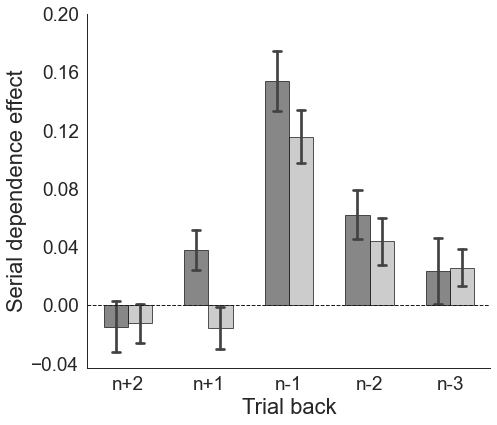

In [64]:
sns.set_theme(style = 'white', font = 'Arial')
paper_rc = {'lines.linewidth': 1.5, 'lines.markersize': 3}     
sns.set_context("paper", rc = paper_rc)
plt.figure(figsize=(7,6))

colors_list = ['#FF7C15','#00A087FF']
colors_list = ['dimgray','silver']

reg_seq_con_CurHigh = reg_seq_con.drop(reg_seq_con[reg_seq_con['TrialType']=='Low'].index)

PlotData = reg_seq_con_CurHigh.groupby(['nBack','SubID','nBack_TrialType']).agg({'Slope':'mean'}).reset_index()

ax = sns.barplot(x='nBack',y='Slope',hue="nBack_TrialType",data=PlotData,
                   hue_order=['High','Low'], palette=colors_list,
                   dodge = True,errorbar=('se', 1),capsize=0.1,
                 width=0.6, alpha=0.8,edgecolor='black') 


plt.yticks([ -0.04, 0.0, 0.04, 0.08, 0.12, 0.16, 0.20])
plt.axhline(y=0, color='k', linestyle='--',linewidth=1)

plt.xlabel('Trial back', fontsize=22)
plt.ylabel('Serial dependence effect', fontsize=22)
ax.set_xticklabels(['n+2','n+1','n-1','n-2','n-3'])

plt.xticks(fontsize=19)
plt.yticks(fontsize=19)

sns.despine(top=True,right=True,left=False,bottom=False)

# remove legend box
plt.legend(loc='best',fontsize = 20)
plt.gca().get_legend().get_frame().set_linewidth(0)
plt.legend([],[], frameon=False)
plt.tick_params(top=False,bottom=False,left=False,right=False)

plt.tight_layout()
plt.savefig(FigurePath+"/nBack_currentHigh.png", dpi=600)
#plt.savefig(FigurePath+"/SerialDep_Feedback_pointplot.eps", dpi=600)
plt.show()


In [65]:
reg_seq_con_CurHigh.groupby(['nBack','SubID','nBack_TrialType']).agg({ 'Slope': ['mean', 'sem'],'Intercept': ['mean', 'sem']}).reset_index()
reg_seq_con_CurHigh = reg_seq_con_CurHigh.sort_values(by=['nBack','SubID','nBack_TrialType'])
reg_seq_con_CurHigh




,nBack,TrialType,nBack_TrialType,SubID,Intercept,Slope,p
21,-2,High,High,1.0,-0.169692,0.082889,0.397509
0,-2,High,Low,1.0,0.025994,-0.044853,0.507124
22,-2,High,High,2.0,0.030618,-0.010964,0.884670
1,-2,High,Low,2.0,-0.076364,0.049202,0.358458
23,-2,High,High,3.0,-0.289745,0.149820,0.151311
...,...,...,...,...,...,...,...
354,3,High,Low,19.0,-0.048655,0.079933,0.157796
376,3,High,High,20.0,0.190962,-0.078343,0.204826
355,3,High,Low,20.0,0.040334,0.034593,0.529821
377,3,High,High,21.0,-0.010948,0.015543,0.798062


In [66]:
reg_seq_con_CurHigh

reg_seq_con_CurHigh_OneFuture = reg_seq_con_CurHigh.query(' nBack != 1 & nBack != 2 & nBack != 3 ')


reg_seq_con_CurHigh_OneFuture = reg_seq_con_CurHigh_OneFuture.sort_values(by=['nBack_TrialType','SubID'])
reg_seq_con_CurHigh_OneFuture


,nBack,TrialType,nBack_TrialType,SubID,Intercept,Slope,p
21,-2,High,High,1.0,-0.169692,0.082889,0.397509
105,-1,High,High,1.0,0.021241,-0.038924,0.609389
22,-2,High,High,2.0,0.030618,-0.010964,0.884670
106,-1,High,High,2.0,-0.029885,0.023429,0.712930
23,-2,High,High,3.0,-0.289745,0.149820,0.151311
...,...,...,...,...,...,...,...
102,-1,High,Low,19.0,0.038243,-0.004262,0.942514
19,-2,High,Low,20.0,0.171855,-0.063920,0.225051
103,-1,High,Low,20.0,0.196900,-0.087802,0.142903
20,-2,High,Low,21.0,-0.036858,0.048621,0.349756


In [67]:
reg_seq_con_CurHigh.groupby(['nBack','nBack_TrialType']).agg({'Slope': ['mean', 'sem'],'Intercept': ['mean', 'sem']}).reset_index().round(3)



nBack nBack_TrialType  Slope        Intercept       
                          mean    sem      mean    sem
0    -2            High -0.015  0.018     0.004  0.032
1    -2             Low -0.013  0.013    -0.001  0.018
2    -1            High  0.037  0.014    -0.059  0.024
3    -1             Low -0.016  0.014     0.003  0.024
4     1            High  0.154  0.021    -0.200  0.032
5     1             Low  0.115  0.018    -0.153  0.025
6     2            High  0.062  0.017    -0.093  0.025
7     2             Low  0.043  0.016    -0.063  0.021
8     3            High  0.023  0.023    -0.041  0.029
9     3             Low  0.025  0.013    -0.045  0.018

In [68]:
for k in sorted(reg_seq_con_CurHigh['nBack'].unique()):
    print('======================================= nBack =========================================:',k)
    sub = reg_seq_con_CurHigh.query('nBack == @k').groupby(['SubID','nBack_TrialType']).agg({'Slope': 'mean'}).reset_index()
    print('---- Prior Low ----:')
    Same_seq_stats = pg.ttest(sub[sub['nBack_TrialType']=='Low']['Slope'],0)
    pg.print_table(Same_seq_stats, floatfmt='.5f')
    
    print('---- Prior High ----:')
    Different_seq_stats = pg.ttest(sub[sub['nBack_TrialType']=='High']['Slope'],0)
    pg.print_table(Different_seq_stats, floatfmt='.5f')   
    
    print('---- Prior Low vs Prior High ----:')
    Same_Diff_seq_stats = pg.pairwise_tests(data=sub, dv='Slope', within='nBack_TrialType', subject='SubID',  effsize='cohen')
    pg.print_table(Same_Diff_seq_stats, floatfmt='.5f')    
    
    

======================================= nBack =========================================: -2
---- Prior Low ----:
       T    dof  alternative      p-val  CI95%            cohen-d     BF10    power
--------  -----  -------------  -------  -------------  ---------  -------  -------
-0.96754     20  two-sided      0.34483  [-0.04  0.01]    0.21113  0.34500  0.15154

---- Prior High ----:
       T    dof  alternative      p-val  CI95%            cohen-d     BF10    power
--------  -----  -------------  -------  -------------  ---------  -------  -------
-0.85244     20  two-sided      0.40407  [-0.05  0.02]    0.18602  0.31500  0.12829

---- Prior Low vs Prior High ----:

POST HOC TESTS

Contrast         A     B    Paired    Parametric           T       dof  alternative      p-unc     BF10     cohen
---------------  ----  ---  --------  ------------  --------  --------  -------------  -------  -------  --------
nBack_TrialType  High  Low  True      True          -0.10128  20.00000  two-sid

In [69]:
pvals = [0.34483, 0.27562, 0.00000, 0.01379, 0.05952]
reject, pvals_corr = pg.multicomp(pvals, method='bonf')
print(reject, pvals_corr)

[False False  True False False] [1.      1.      0.      0.06895 0.2976 ]


In [70]:
pvals = [0.40407, 0.01348, 0.00000, 0.00134, 0.31362]
reject, pvals_corr = pg.multicomp(pvals, method='bonf')
print(reject, pvals_corr)

[False False  True  True False] [1.     0.0674 0.     0.0067 1.    ]


Future duration 0.8
Future duration 1.0
Future duration 1.2
Future duration 1.4
Future duration 1.6


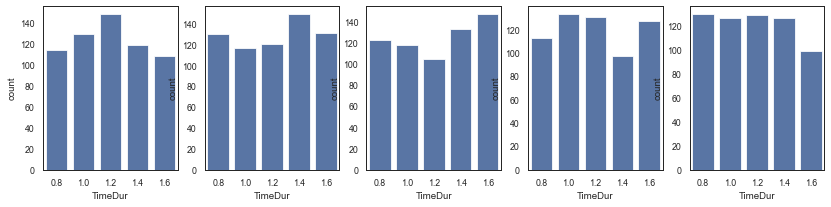

,nBack_Time,TimeDur
0,0.8,1.209627
1,1.0,1.202856
2,1.2,1.203995
3,1.4,1.192019
4,1.6,1.193900


In [83]:
# replace raw data value 9999 with NaN
rawFuture = AllBackData.query('nBack == {}'.format(-1))


rawFuture = rawFuture.drop(rawFuture[rawFuture['Condition']=='0.0'].index)
rawFuture['Condition_Prior'] = rawFuture['Condition'].str.slice(0, 1) 
rawFuture['Condition_Prior'] = rawFuture['Condition_Prior'].map({"L": 'PriorLow', "H": 'PriorHigh'})
rawFuture

np.sort(rawFuture['nBack_Time'].unique())

MeanCurrentData = rawFuture.groupby(['nBack_Time']).agg({'TimeDur':'mean'}).reset_index()

PriorDur = np.sort(rawFuture['nBack_Time'].unique())
index = 0
fig, ax =plt.subplots(1,5,figsize=(14, 3))

for i in PriorDur:
    print('Future duration',i)
    
    HH = rawFuture[(rawFuture["Condition"] == 'HH')]
    plotdataCur = HH.query('nBack_Time == {}'.format(i))
    
    sns.countplot(plotdataCur, x="TimeDur",color = 'b', ax=ax[index])
    index = index+1
    
plt.show()

MeanCurrentData